In [56]:
# plot distribution of emotion in a list of logits
# using the pre-computed logits in cache/ (obtained by running emotion_tree_get_logits.py)

# from nnsight import CONFIG
from nnsight import LanguageModel
# import os
import numpy as np
import pickle
import torch
import more_itertools
from collections import defaultdict
from collections import Counter

import seaborn as sns

import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


In [57]:
filename = 'llama-405'
model_name = 'meta-llama/Meta-Llama-3.1-405B'
model = LanguageModel(model_name, device_map="auto")


In [58]:
with open('data/emotion_wheel_SSKO.pkl', 'rb') as f:
    SSKO, _, _ = pickle.load(f)
emotion_words = list(more_itertools.collapse(SSKO))
print("total number of emotions:", len(emotion_words))
print(len(SSKO[0]))
for i in range(len(SSKO[1])):
    print(len(SSKO[1][i]))


total number of emotions: 135
6
15
32
2
28
36
16


## Confusion matrix

In [102]:
def compute_confusion_matrix(emotion_words, logits_list, weighted=False, primary_emotion_only=False):
    max_probs_list = []
    # tokens_list = []
    words = []
    for i in range(len(logits_list)):
        max_probs, tokens = logits_list[i].topk(100, largest=True, dim=-1) # [0, 1], int
        max_probs_list.append(max_probs)
        # tokens_list.append(tokens)
        word_str = [model.tokenizer.decode(t).encode("unicode_escape").decode() for t in tokens][0]
        word_list = re.findall(r"'\s*|\w+", word_str) #word_str.split()
        words.append(word_list)
        # print(max_probs.sum()) # should be close to 1

    max_probs = torch.cat(max_probs_list) # size 5000 x 100
    # tokens = torch.cat(tokens_list) # size 5000 x 100

    if primary_emotion_only == False:
        emotion_to_idx = {word: idx for idx, word in enumerate(emotion_words)}
        confusion_matrix = np.zeros((135, 135))
        
        for i in range(2700):
            actual_emotion = i // 20  # 20 sentences per emotion
    
            if weighted == False:
                predicted_emotion = -1
                for word in words[i]:
                    if word in emotion_to_idx:
                        predicted_emotion = emotion_to_idx[word]
                        break
                
                if predicted_emotion != -1:
                    confusion_matrix[actual_emotion, predicted_emotion] += 1
            else:
                for word_idx, word in enumerate(words[i]):
                    if word in emotion_to_idx:
                        predicted_emotion = emotion_to_idx[word]
                        confusion_matrix[actual_emotion, predicted_emotion] += max_probs[i][word_idx]
                        
    else: #primary_emotion_only == True:
        
        # Mapping of emotions to primary emotion classes
        primary_emotion_mapping = {
            0: 0,  # Emotion 0 -> Primary Class 0
            1: 1,  # Emotion 1 -> Primary Class 1
            2: 2,  # Emotion 2 -> Primary Class 2
            3: 3,  # Emotion 3 -> Primary Class 3
            4: 4,  # Emotion 4 -> Primary Class 4
            5: 5,  # Emotion 5 -> Primary Class 5
        }
        
        # For emotions 6+, mapping them to primary emotions based on blocks
        # Add the emotions that belong to primary classes
        primary_emotion_mapping.update({6 + i: 0 for i in range(15)})   # First block of 15 to Class 0
        primary_emotion_mapping.update({21 + i: 1 for i in range(32)})  # Next block of 32 to Class 1
        primary_emotion_mapping.update({53 + i: 2 for i in range(2)})   # Next block of 2 to Class 2
        primary_emotion_mapping.update({55 + i: 3 for i in range(28)})  # Next block of 28 to Class 3
        primary_emotion_mapping.update({83 + i: 4 for i in range(36)})  # Next block of 36 to Class 4
        primary_emotion_mapping.update({119 + i: 5 for i in range(16)}) # Next block of 16 to Class 5
        
        # Create a mapping from emotion words to their corresponding primary emotion classes
        emotion_to_primary_class = {}
        for idx, word in enumerate(emotion_words):
            if idx in primary_emotion_mapping:
                emotion_to_primary_class[word] = primary_emotion_mapping[idx]
        
        # Initialize a 6x6 confusion matrix for the primary emotions
        num_primary_emotions = 6
        confusion_matrix = np.zeros((num_primary_emotions, num_primary_emotions), dtype=int)

        for i in range(2700):
            actual_emotion = i // 20  # 20 sentences per emotion
            if actual_emotion in primary_emotion_mapping:
                actual_primary_class = primary_emotion_mapping[actual_emotion]
            else:
                print("the actual emotion doesn't have a mapping to a primary class")
                break
    
            predicted_emotion = -1
            for word in words[i]:
                if word in emotion_to_primary_class:
                    predicted_emotion = emotion_to_primary_class[word]
                    break
            
            if predicted_emotion != -1:
                confusion_matrix[actual_primary_class, predicted_emotion] += 1

    return confusion_matrix
    

In [103]:
def plot_confusion_matrix(confusion_matrix, save_filename, color_center_0 = False):
    plt.figure(figsize=(15, 12))  # You can adjust the size depending on the number of emotions

    if color_center_0:
        colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]  # Define color stops at 0 and 1
        custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
        norm = TwoSlopeNorm(vmin=confusion_matrix.min(), vcenter=0, vmax=confusion_matrix.max())
        sns.heatmap(confusion_matrix, annot=False, fmt="d", cmap=custom_cmap, norm=norm, cbar=True)
    else:
        custom_cmap = 'Blues'
        # Create a heatmap using seaborn
        sns.heatmap(confusion_matrix, annot=False, fmt="d", cmap=custom_cmap, cbar=True)

    # Add red lines to block out the regions
    block_sizes = [6, 15, 32, 2, 28, 36, 16]
    block_positions = np.cumsum(block_sizes)  # Cumulative sum to get the positions of the blocks
    for pos in block_positions:
        plt.axhline(y=pos, color='red', linestyle='-', linewidth=1)
        plt.axvline(x=pos, color='red', linestyle='-', linewidth=1)
    
    plt.xlabel("Predicted Emotion", fontsize=24)
    plt.ylabel("Actual Emotion", fontsize=24)
    plt.xticks(ticks=np.arange(0.5, 135.5, 1), labels=[emotion_words[i] for i in range(135)], rotation=90, fontsize=7)
    plt.yticks(ticks=np.arange(0.5, 135.5, 1), labels=[emotion_words[i] for i in range(135)], rotation=0, fontsize=7)
    plt.savefig(save_filename, dpi=400, bbox_inches='tight')
    # plt.show()
    plt.close()



In [104]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_neutral_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_neutral = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_neutral,weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_neutral.pdf')
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_neutral, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_neutral_weighted.pdf')
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_neutral, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_neutral_primary.pdf')


In [105]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_male_llama_neutral_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix_male_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_male_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_male_llama_neutral.pdf')
confusion_matrix_male_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_male_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_male_llama_neutral_weighted.pdf')
confusion_matrix_male_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_male_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_male_llama_neutral_primary.pdf')

with open('cache/hidden_states_{}/chatgpt4o_scenario_female_llama_neutral_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix_female_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_female_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_female_llama_neutral.pdf')
confusion_matrix_female_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_female_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_female_llama_neutral_weighted.pdf')
confusion_matrix_female_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_female_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_female_llama_neutral_primary.pdf')

plot_confusion_matrix(confusion_matrix_male_1 - confusion_matrix_female_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_male-female_llama_neutral.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_male_2 - confusion_matrix_female_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_male-female_llama_neutral_weighted.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_male_3 - confusion_matrix_female_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_male-female_llama_neutral_primary.pdf', color_center_0=True)



In [106]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_male_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix_male_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_male_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_male.pdf')
confusion_matrix_male_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_male_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_male_weighted.pdf')
confusion_matrix_male_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_male_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_male_primary.pdf')

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_female_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix_female_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_female_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_female.pdf')
confusion_matrix_female_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_female_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_female_weighted.pdf')
confusion_matrix_female_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_female_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_female_primary.pdf')

plot_confusion_matrix(confusion_matrix_male_1 - confusion_matrix_female_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_male-female.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_male_2 - confusion_matrix_female_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_male-female_weighted.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_male_3 - confusion_matrix_female_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_male-female_primary.pdf', color_center_0=True)


In [107]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_asian_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix_asian_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_asian_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_asian.pdf')
confusion_matrix_asian_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_asian_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_asian_weighted.pdf')
confusion_matrix_asian_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_asian_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_asian_primary.pdf')

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_american_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix_american_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_american_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_american.pdf')
confusion_matrix_american_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_american_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_american_weighted.pdf')
confusion_matrix_american_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_american_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_american_primary.pdf')

plot_confusion_matrix(confusion_matrix_asian_1 - confusion_matrix_american_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_asian-american.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_asian_2 - confusion_matrix_american_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_asian-american_weighted.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_asian_3 - confusion_matrix_american_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_asian-american_primary.pdf', color_center_0=True)


In [108]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_able_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix_asian_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_asian_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able.pdf')
confusion_matrix_asian_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_asian_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able_weighted.pdf')
confusion_matrix_asian_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_asian_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able_primary.pdf')

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_disable_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix_american_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_american_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_disable.pdf')
confusion_matrix_american_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_american_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_disable_weighted.pdf')
confusion_matrix_american_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_american_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_disable_primary.pdf')

plot_confusion_matrix(confusion_matrix_asian_1 - confusion_matrix_american_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able-disable.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_asian_2 - confusion_matrix_american_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able-disable_weighted.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_asian_3 - confusion_matrix_american_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able-disable_primary.pdf', color_center_0=True)


In [109]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_age10_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix_10_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_10_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_age10.pdf')
confusion_matrix_10_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_10_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_age10_weighted.pdf')
confusion_matrix_10_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_10_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_age10_primary.pdf')

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_age30_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix_30_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_30_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_age30.pdf')
confusion_matrix_30_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_30_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_age30_weighted.pdf')
confusion_matrix_30_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_30_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_age30_primary.pdf')

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_age70_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix_70_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_70_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_age70.pdf')
confusion_matrix_70_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_70_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_age70_weighted.pdf')
confusion_matrix_70_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_70_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_age70_primary.pdf')


plot_confusion_matrix(confusion_matrix_30_1 - confusion_matrix_10_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_30-10.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_70_1 - confusion_matrix_30_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_70-30.pdf', color_center_0=True)
plot_confusion_matrix(confusion_matrix_70_1 - confusion_matrix_10_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_70-10.pdf', color_center_0=True)


In [112]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_income-high_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix_high_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_high_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_income-high.pdf')
confusion_matrix_high_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_high_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_income-high_weighted.pdf')
confusion_matrix_high_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_high_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_income-high_primary.pdf')

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_income-low_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix_low_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_low_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_income-low.pdf')
confusion_matrix_low_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_low_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_income-low_weighted.pdf')
confusion_matrix_low_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_low_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_income-low_primary.pdf')

plot_confusion_matrix(confusion_matrix_high_1 - confusion_matrix_low_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_income-high-low.pdf', color_center_0=True)
# plot_confusion_matrix(confusion_matrix_asian_2 - confusion_matrix_american_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able-disable_weighted.pdf', color_center_0=True)
# plot_confusion_matrix(confusion_matrix_asian_3 - confusion_matrix_american_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able-disable_primary.pdf', color_center_0=True)


In [113]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_education_high_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix_high_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_high_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_education_high.pdf')
confusion_matrix_high_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_high_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_education_high_weighted.pdf')
confusion_matrix_high_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_high_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_education_high_primary.pdf')

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_education_low_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix_low_1 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_low_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_education_low.pdf')
confusion_matrix_low_2 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
plot_confusion_matrix(confusion_matrix_low_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_education_low_weighted.pdf')
confusion_matrix_low_3 = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=False, primary_emotion_only=True)
plot_confusion_matrix(confusion_matrix_low_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_education_low_primary.pdf')

plot_confusion_matrix(confusion_matrix_high_1 - confusion_matrix_low_1, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_education-high-low.pdf', color_center_0=True)
# plot_confusion_matrix(confusion_matrix_asian_2 - confusion_matrix_american_2, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able-disable_weighted.pdf', color_center_0=True)
# plot_confusion_matrix(confusion_matrix_asian_3 - confusion_matrix_american_3, 'figures/bias/confusion_matrix_chatgpt4o_scenario_neutral_llama_able-disable_primary.pdf', color_center_0=True)


## Histogram

In [127]:
# plot histogram 
def plot_histogram(filename, model_name, logits_list_filename):
    with open('cache/hidden_states_{}/{}.pkl'.format(filename, logits_list_filename), 'rb') as f:
        logits_list = pickle.load(f) # size 2700 x 128256

    model = LanguageModel(model_name, device_map="auto")

    # Find the top 100 probability and corresponding tokens for each prompt
    max_probs_list = []
    tokens_list = []
    words = []
    for i in range(len(logits_list)):
        max_probs, tokens = logits_list[i].topk(100, largest=True, dim=-1) # [0, 1], int
        max_probs_list.append(max_probs)
        tokens_list.append(tokens)
        word_str = [model.tokenizer.decode(t).encode("unicode_escape").decode() for t in tokens][0]
        word_list = re.findall(r"'\s*|\w+", word_str) #word_str.split()
        words.append(word_list)
        # print(max_probs.sum()) # should be close to 1

    max_probs = torch.cat(max_probs_list) # size 2700 x 100
    tokens = torch.cat(tokens_list) # size 2700 x 100

    ########################################################################################
    # List to store the first emotion word found in each list of words
    first_emotion_words = []
    
    # Iterate over each list of words
    for word_list in words:
        # Find the first word in the list that is in emotion_words
        first_emotion = next((word for word in word_list if word in emotion_words), None)
        # Add it to the result if found
        if first_emotion:
            first_emotion_words.append(first_emotion)
    
    # Count the occurrences of each first emotion word
    word_frequencies = Counter(first_emotion_words)
    
    # Sort the word frequencies in descending order and select the top 20
    most_common_words = word_frequencies.most_common(30)
    
    # Separate words and their counts for plotting
    words_to_plot, frequencies_to_plot = zip(*most_common_words)
    
    # Create a wider figure (width=12, height=6 for example)
    plt.figure(figsize=(20, 6))
    
    # Plot a sorted histogram of the top 20 most frequent emotion words
    plt.bar(words_to_plot, frequencies_to_plot)
    plt.xticks(rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Frequency', fontsize=26)
    # plt.title('Top 20 Most Frequent First Emotion Words')

    # Add text to the upper-right corner (coordinates will adjust based on data)
    if filename[0] == 'l':
        filename = filename + 'B'
    plt.text(len(words_to_plot) - 1, max(frequencies_to_plot) * 0.95, filename, 
         fontsize=30, ha='right', va='top', color='black')

    plt.tight_layout()  # Adjust layout so everything fits nicely
    plt.savefig('figures/bias/histogram_top_1_{}.pdf'.format(logits_list_filename), dpi=400, bbox_inches='tight')

    ########################################################################################
    # Dictionary to accumulate the sum of probabilities for each emotion word
    emotion_word_prob_sums = defaultdict(float)
    
    # Iterate over each list of words and corresponding probabilities
    for i, word_list in enumerate(words):
        probs = max_probs[i]  # Get the corresponding probabilities for this word list
        # Iterate through the word list and accumulate probabilities for emotion words
        for j, word in enumerate(word_list):
            if word in emotion_words:
                emotion_word_prob_sums[word] += probs[j].item()  # Convert tensor value to float and accumulate
    
    # Prepare data for plotting (sorted by summed probabilities)
    sorted_emotion_words = sorted(emotion_word_prob_sums.items(), key=lambda x: x[1], reverse=True)
    
    # Slice the top 30 emotions
    top_30_emotions = sorted_emotion_words[:30]
    words_to_plot, summed_probabilities_to_plot = zip(*top_30_emotions)
    
    # Create a wider figure
    plt.figure(figsize=(20, 6))
    
    # Plot the histogram where the frequency is the sum of probabilities
    plt.bar(words_to_plot, summed_probabilities_to_plot)
    
    # Set labels and title with larger font size
    plt.ylabel('Weighted Frequency', fontsize=26)
    # plt.title('Top 30 Emotion Words by Summed Probabilities', fontsize=18)
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)

    # Add text to the upper-right corner (coordinates will adjust based on data)
    plt.text(len(words_to_plot) - 1, max(summed_probabilities_to_plot) * 0.95, filename, 
         fontsize=30, ha='right', va='top', color='black')
    
    # Display the plot
    plt.tight_layout()
    plt.savefig('figures/bias/histogram_top_100_summed_probabilities_{}.pdf'.format(logits_list_filename), dpi=400, bbox_inches='tight')


    ########################################################################################
    # List to store the first emotion word found in each list of words (primary emotion only)
    
    # Mapping of emotions to primary emotion classes
    primary_emotion_mapping = {
        0: 0,  # Emotion 0 -> Primary Class 0
        1: 1,  # Emotion 1 -> Primary Class 1
        2: 2,  # Emotion 2 -> Primary Class 2
        3: 3,  # Emotion 3 -> Primary Class 3
        4: 4,  # Emotion 4 -> Primary Class 4
        5: 5,  # Emotion 5 -> Primary Class 5
    }
    
    # For emotions 6+, mapping them to primary emotions based on blocks
    # Add the emotions that belong to primary classes
    primary_emotion_mapping.update({6 + i: 0 for i in range(15)})   # First block of 15 to Class 0
    primary_emotion_mapping.update({21 + i: 1 for i in range(32)})  # Next block of 32 to Class 1
    primary_emotion_mapping.update({53 + i: 2 for i in range(2)})   # Next block of 2 to Class 2
    primary_emotion_mapping.update({55 + i: 3 for i in range(28)})  # Next block of 28 to Class 3
    primary_emotion_mapping.update({83 + i: 4 for i in range(36)})  # Next block of 36 to Class 4
    primary_emotion_mapping.update({119 + i: 5 for i in range(16)}) # Next block of 16 to Class 5

    
    # Create a mapping from emotion words to their corresponding primary emotion classes
    emotion_to_primary_class = {}
    for idx, word in enumerate(emotion_words):
        if idx in primary_emotion_mapping:
            emotion_to_primary_class[word] = primary_emotion_mapping[idx]

    first_emotion_words = []
    
    # Iterate over each list of words
    for word_list in words:
        # Find the first word in the list that is in emotion_words
        first_emotion = next((word for word in word_list if word in emotion_words), None)
        # Add it to the result if found
        if first_emotion:
            first_emotion_words.append(emotion_to_primary_class[first_emotion])
    
    # Count the occurrences of each first emotion word
    word_frequencies = Counter(first_emotion_words)
    print(word_frequencies)
    
    # Create a wider figure (width=12, height=6 for example)
    plt.figure(figsize=(8, 6))
    
    # Plot a sorted histogram of the top 20 most frequent emotion words
    primary_emotions = ['love', 'joy', 'surprise', 'anger', 'sadness', 'fear']
    print(word_frequencies.keys())
    primary_emotions_freq = []
    for i in range(len(primary_emotions)):
        # print(word_frequencies[i])
        primary_emotions_freq.append(word_frequencies[i])
    plt.bar(primary_emotions, primary_emotions_freq)
    # plt.bar([SSKO[0][list(word_frequencies.keys())[i]] for i in range(len(list(word_frequencies.keys())))], list(word_frequencies.values()))
    plt.xticks(rotation=45, ha='right', fontsize=32)
    plt.yticks([0, 200, 400, 600, 800], fontsize=28)
    plt.ylim(0, 870)
    plt.ylabel('Frequency', fontsize=32)
    plt.tight_layout()
    plt.savefig('figures/bias/histogram_top_1_primary_{}.pdf'.format(logits_list_filename), dpi=400, bbox_inches='tight')

    return primary_emotions_freq



In [149]:
def plot_histogram_combined(primary_emotions_freq_list, category_name, filename):
    primary_emotions = ['love', 'joy', 'surprise', 'anger', 'sadness', 'fear']
        # Create a wider figure (width=12, height=6 for example)

    # Number of categories and emotions
    n_categories = len(primary_emotions_freq_list)
    n_emotions = len(primary_emotions)
    
    # Bar width
    bar_width = 0.2
    
    # Set positions for bars on x-axis
    index = np.arange(n_emotions)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Loop through each category to plot
    for i in range(n_categories):
        # print(index + i * bar_width, primary_emotions_freq_list[i], bar_width)
        ax.bar(index + i * bar_width, primary_emotions_freq_list[i], bar_width, label=category_name[i])
    
    # Add labels and title
    # ax.set_xlabel('Primary Emotions')
    ax.set_ylabel('Frequencies', fontsize=32)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(primary_emotions, rotation=45, fontsize=32)
    # ax.set_xticks([0, 200, 400, 600, 800])
    # ax.set_yticklabels([0, 200, 400, 600, 800], fontsize=28)
    ax.set_ylim(0, 870)

    # Add a legend
    ax.legend()
    
    # # Show the plot
    # plt.tight_layout()
    # plt.show()

    plt.savefig('figures/bias/histogram_top_1_primary_{}.pdf'.format(filename), dpi=400, bbox_inches='tight')




    # plt.figure(figsize=(8, 6))
    # plt.bar(primary_emotions, primary_emotions_freq)
    # plt.xticks(rotation=45, ha='right', fontsize=32)
    # plt.yticks([0, 200, 400, 600, 800], fontsize=28)
    # plt.ylim(0, 870)
    # plt.ylabel('Frequency', fontsize=32)
    # plt.tight_layout()
    # plt.savefig('figures/bias/histogram_top_1_primary_{}.pdf'.format(filename), dpi=400, bbox_inches='tight')


Counter({1: 751, 4: 718, 3: 529, 5: 425, 0: 255, 2: 21})
dict_keys([0, 1, 5, 3, 2, 4])
Counter({1: 734, 4: 685, 3: 588, 5: 418, 0: 241, 2: 32})
dict_keys([0, 1, 2, 5, 3, 4])
Counter({1: 747, 4: 682, 3: 603, 5: 419, 0: 233, 2: 15})
dict_keys([0, 1, 5, 2, 3, 4])
Counter({1: 681, 4: 616, 3: 571, 5: 520, 0: 281, 2: 16})
dict_keys([0, 1, 2, 5, 3, 4])
Counter({1: 678, 4: 598, 5: 536, 3: 527, 0: 274, 2: 11})
dict_keys([0, 1, 2, 5, 3, 4])
Counter({4: 841, 1: 696, 3: 502, 5: 382, 0: 257, 2: 22})
dict_keys([0, 1, 2, 3, 4, 5])
Counter({1: 707, 4: 707, 3: 546, 5: 458, 0: 256, 2: 17})
dict_keys([0, 1, 2, 3, 4, 5])


/var/folders/8p/c9kgv3hd0zlbvsvzb6f644q00000gp/T/ipykernel_64547/581950981.py:150: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


Counter({1: 713, 4: 626, 3: 587, 5: 548, 0: 197, 2: 15})
dict_keys([0, 1, 5, 3, 2, 4])
Counter({1: 659, 5: 656, 3: 640, 4: 539, 0: 159, 2: 5})
dict_keys([0, 1, 5, 3, 2, 4])
Counter({4: 756, 1: 752, 3: 515, 5: 444, 0: 214, 2: 18})
dict_keys([0, 1, 2, 3, 4, 5])
Counter({1: 691, 4: 675, 3: 545, 5: 457, 0: 289, 2: 20})
dict_keys([0, 1, 2, 3, 4, 5])
Counter({4: 715, 1: 692, 3: 529, 5: 455, 0: 284, 2: 24})
dict_keys([0, 1, 2, 5, 3, 4])
Counter({1: 718, 4: 643, 3: 589, 5: 464, 0: 269, 2: 17})
dict_keys([0, 1, 2, 3, 4, 5])
Counter({3: 677, 1: 646, 4: 645, 5: 546, 0: 170, 2: 13})
dict_keys([0, 1, 3, 4, 5, 2])
Counter({1: 689, 4: 681, 3: 575, 5: 436, 0: 298, 2: 19})
dict_keys([0, 1, 2, 3, 4, 5])
Counter({1: 681, 4: 669, 3: 578, 5: 480, 0: 269, 2: 19})
dict_keys([0, 1, 2, 3, 4, 5])


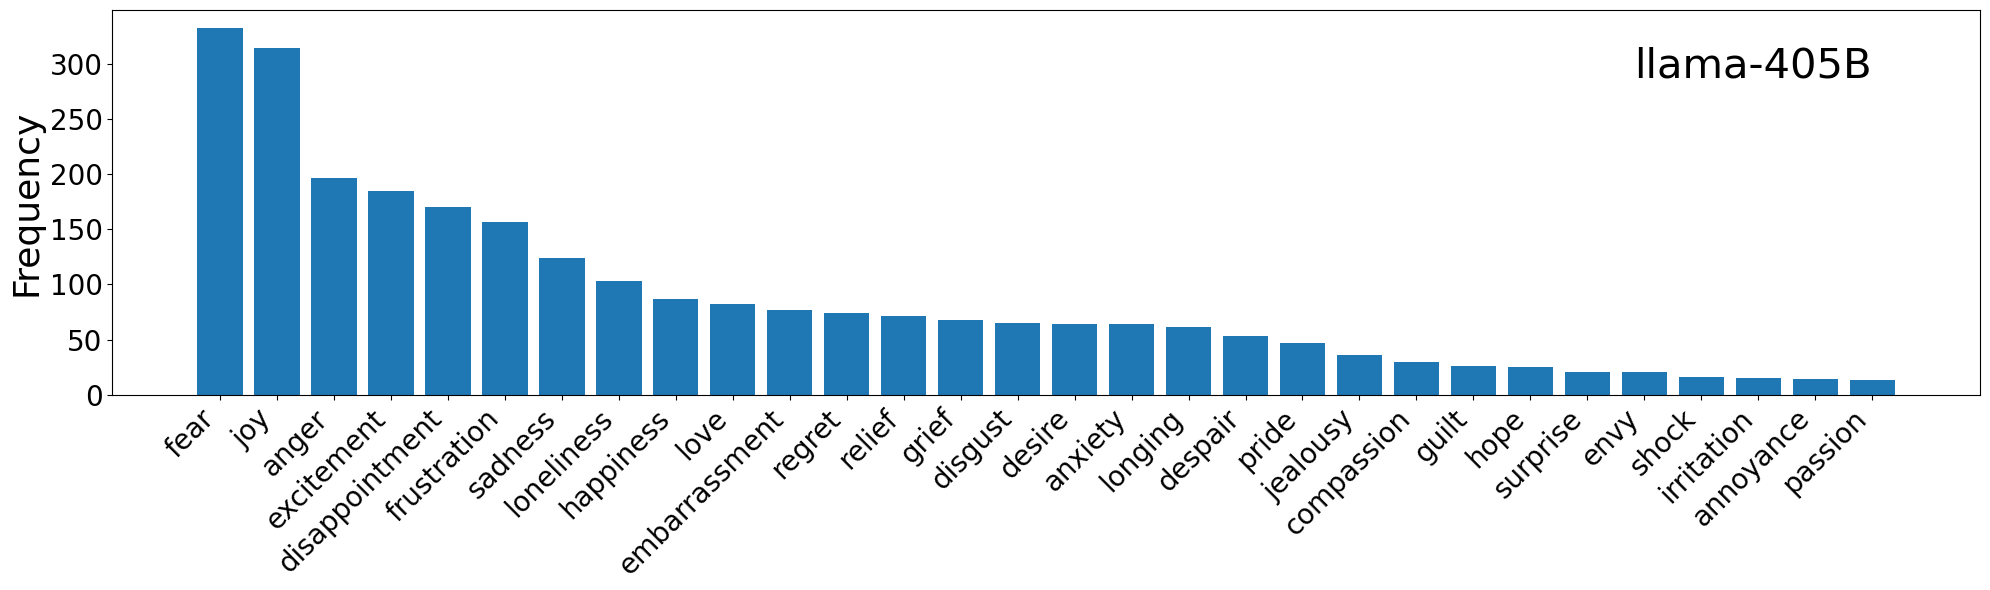

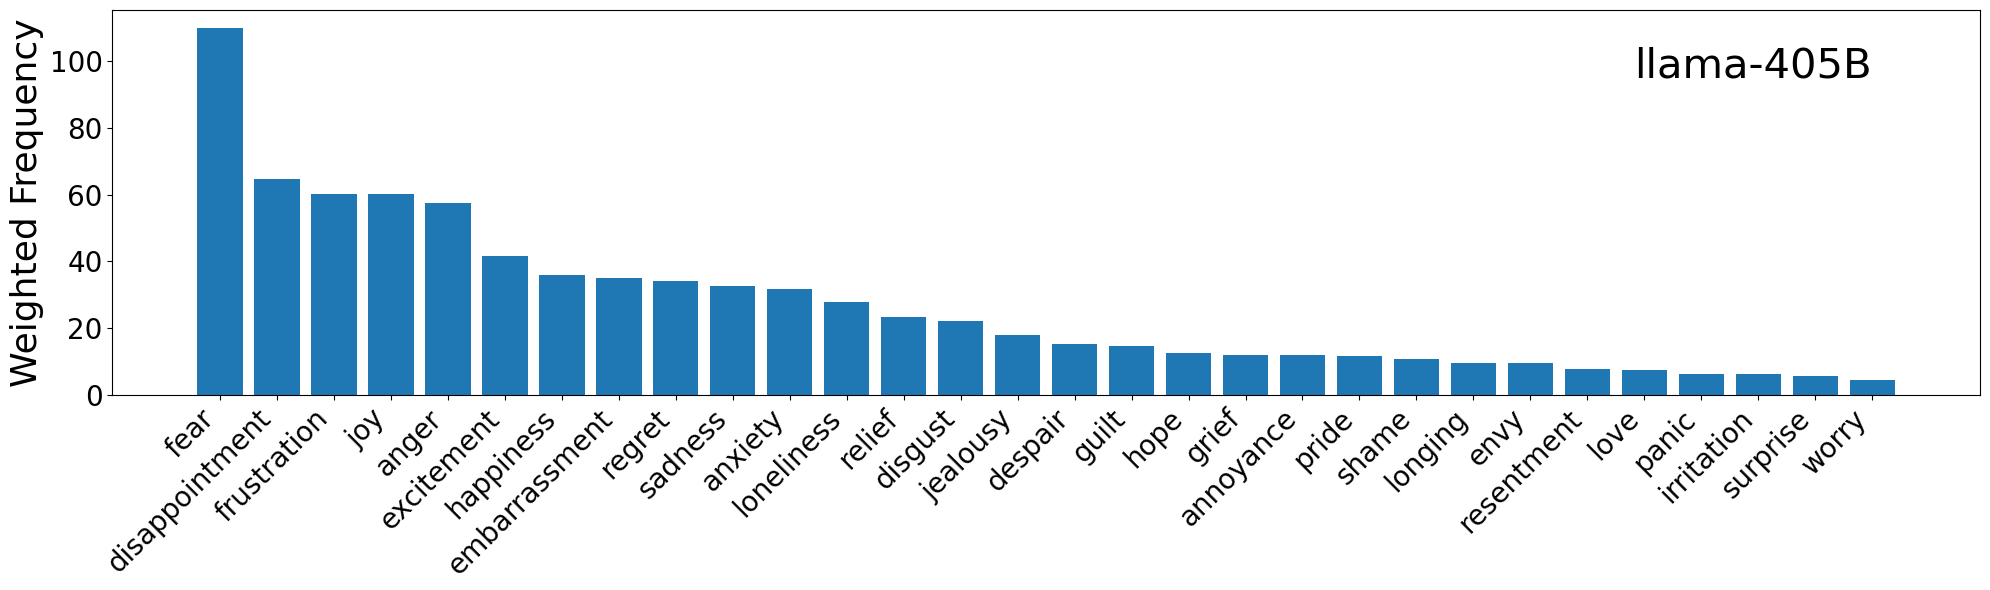

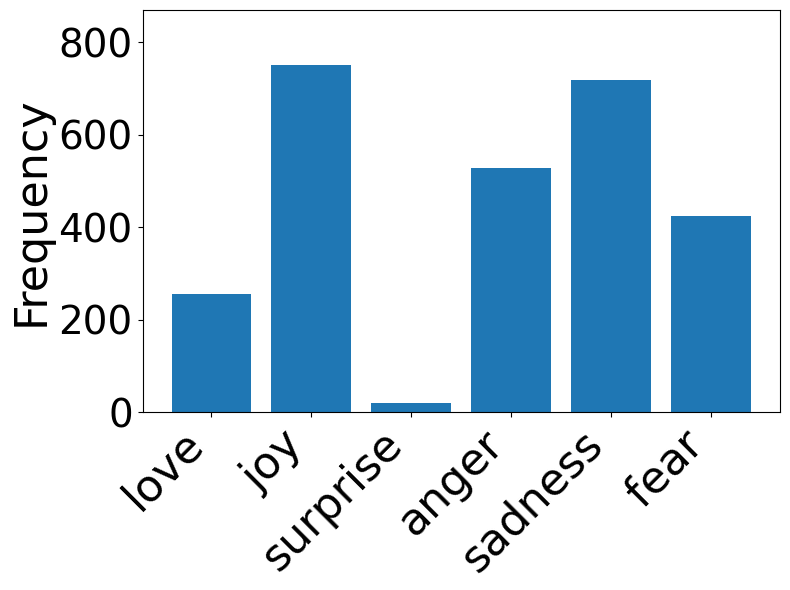

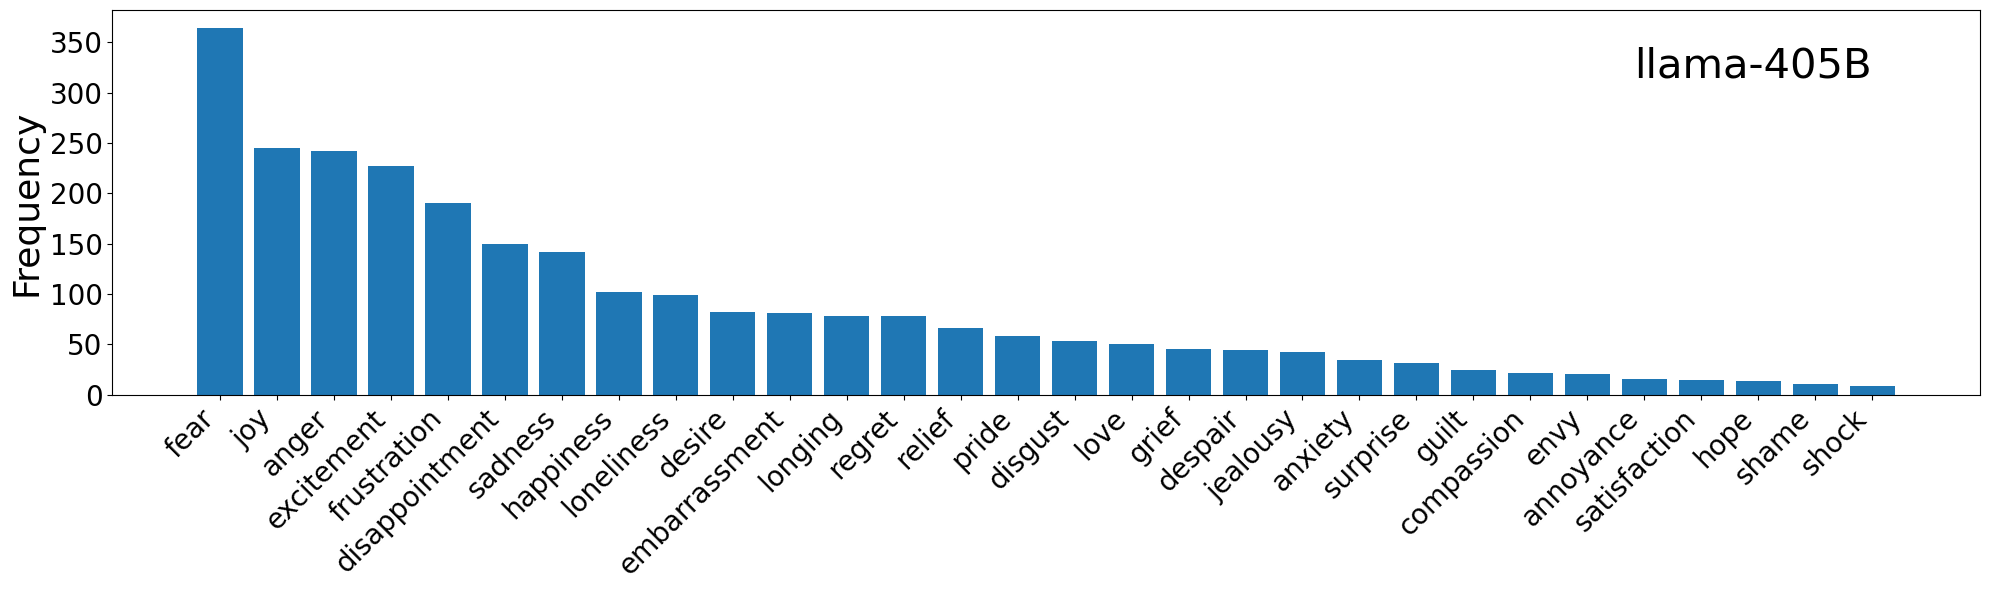

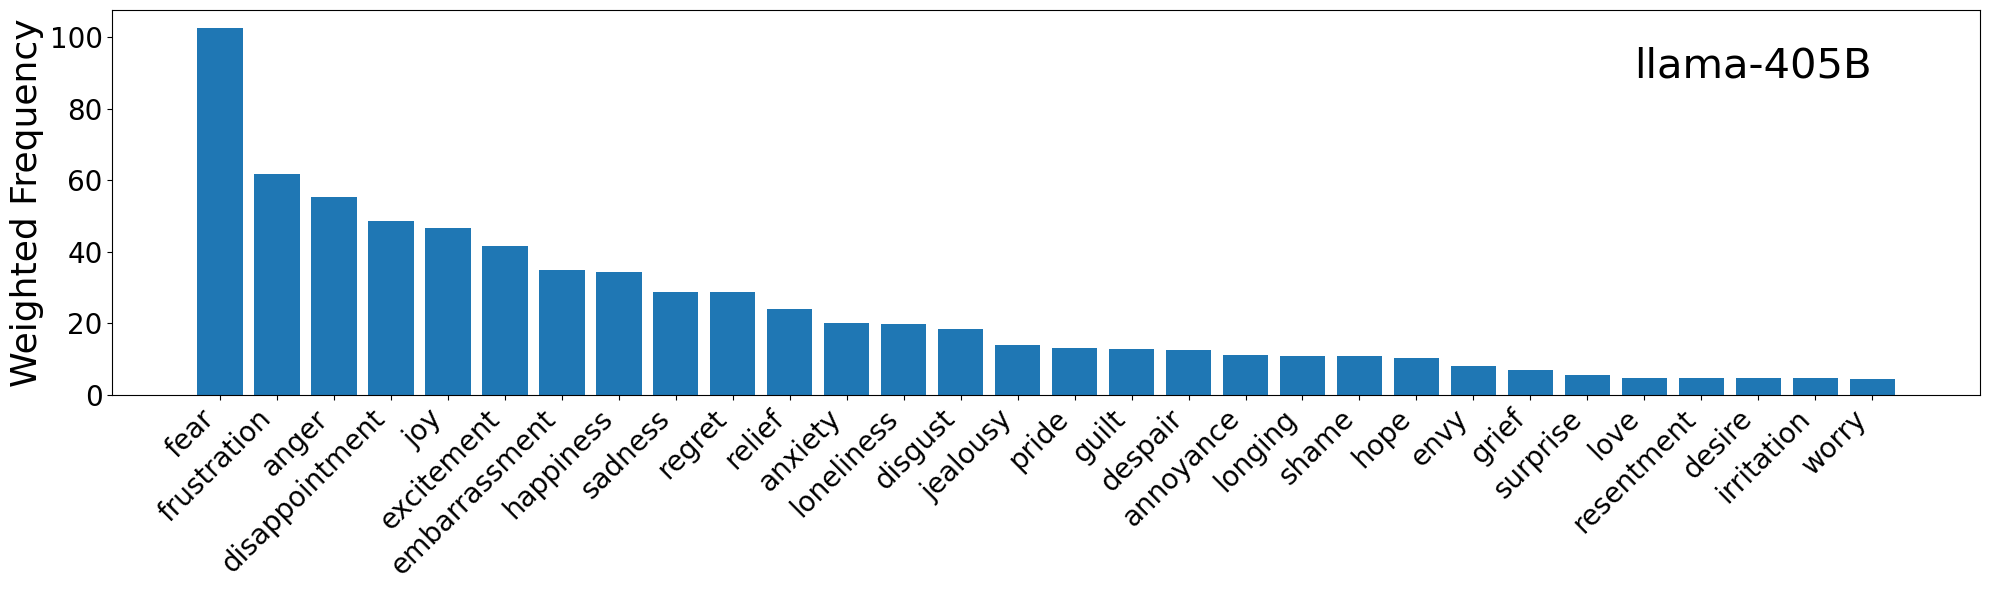

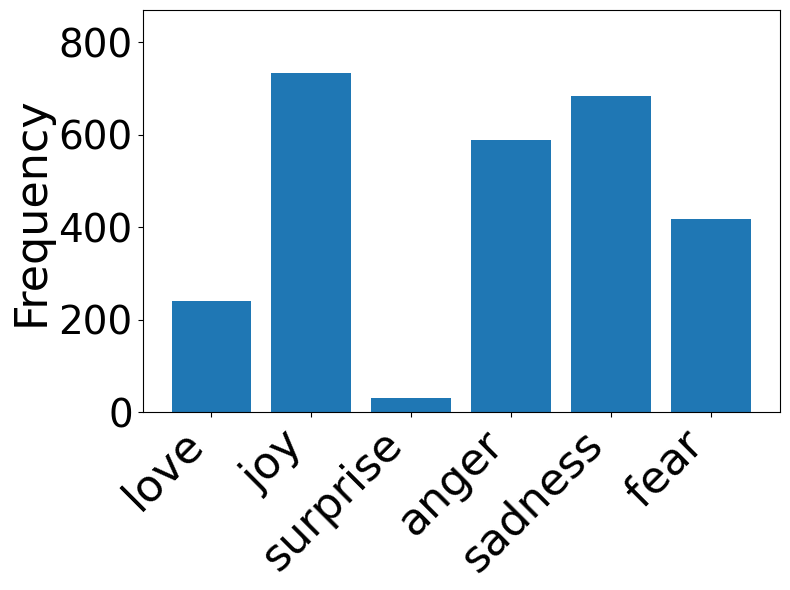

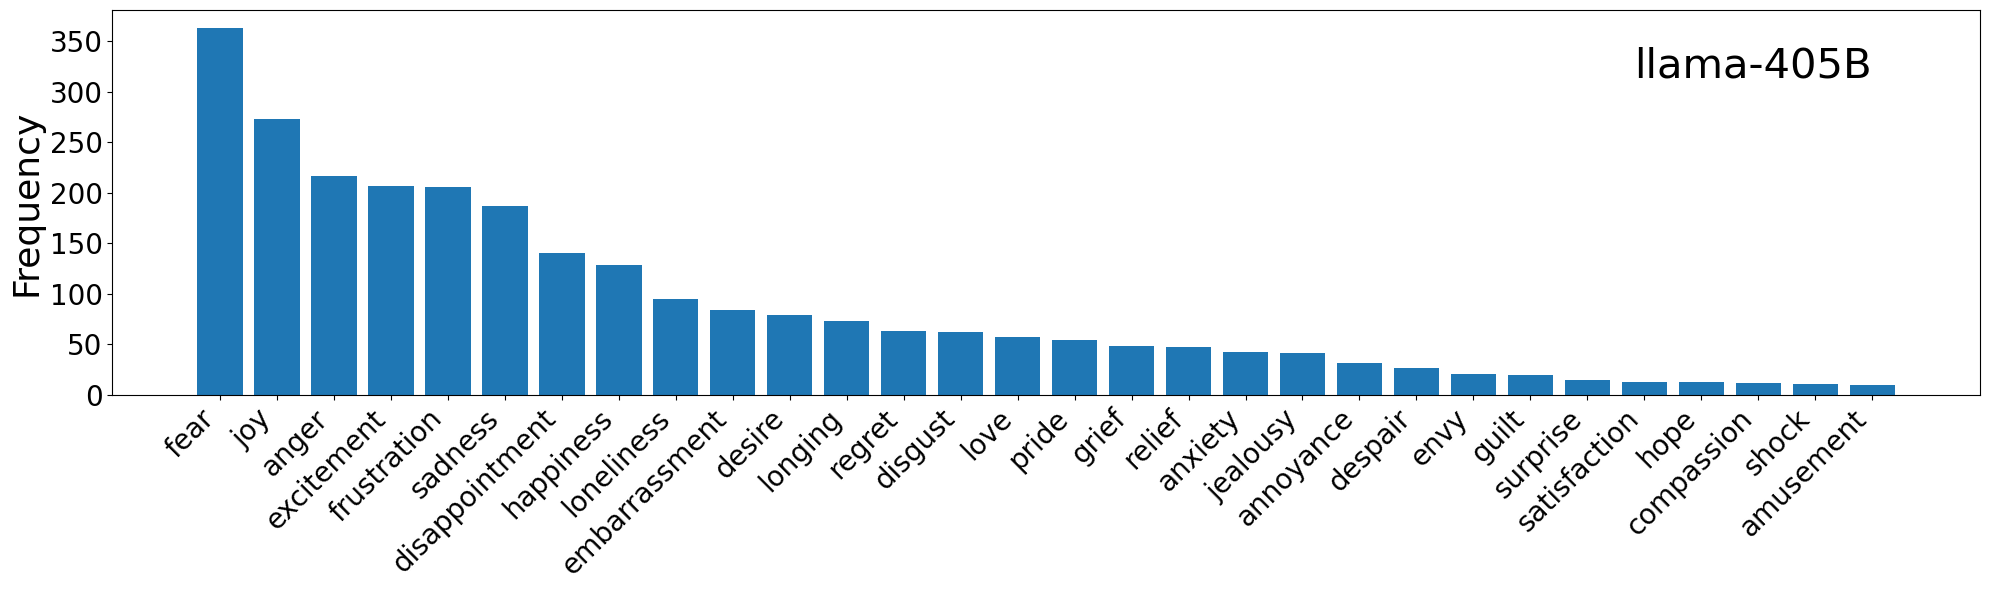

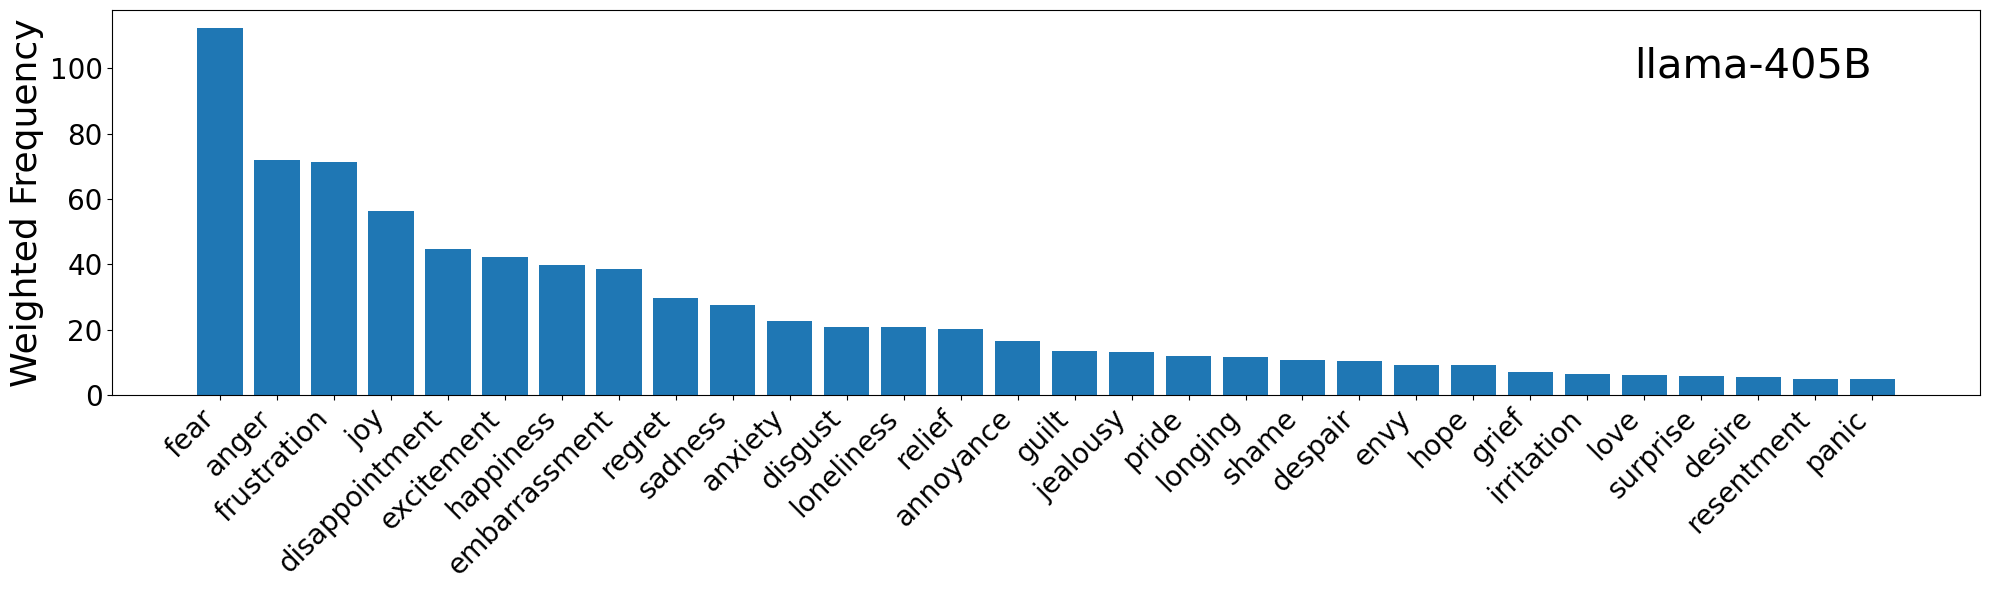

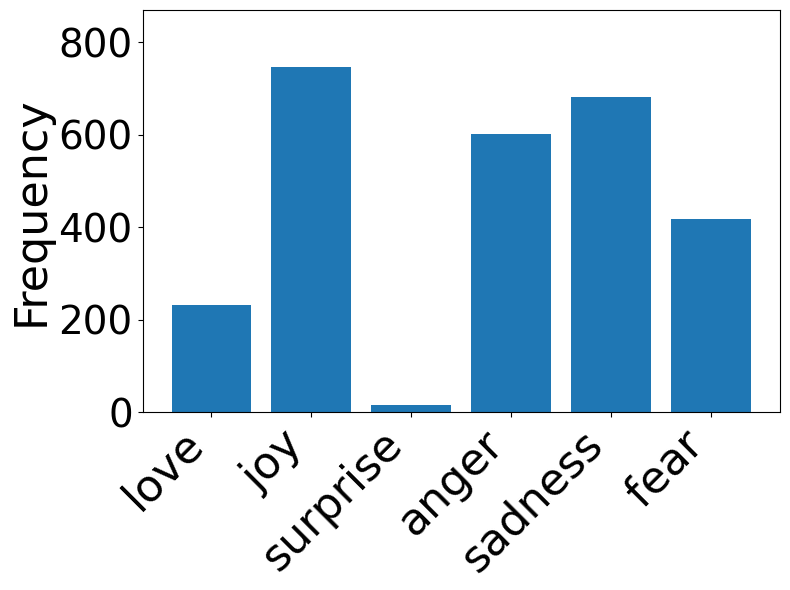

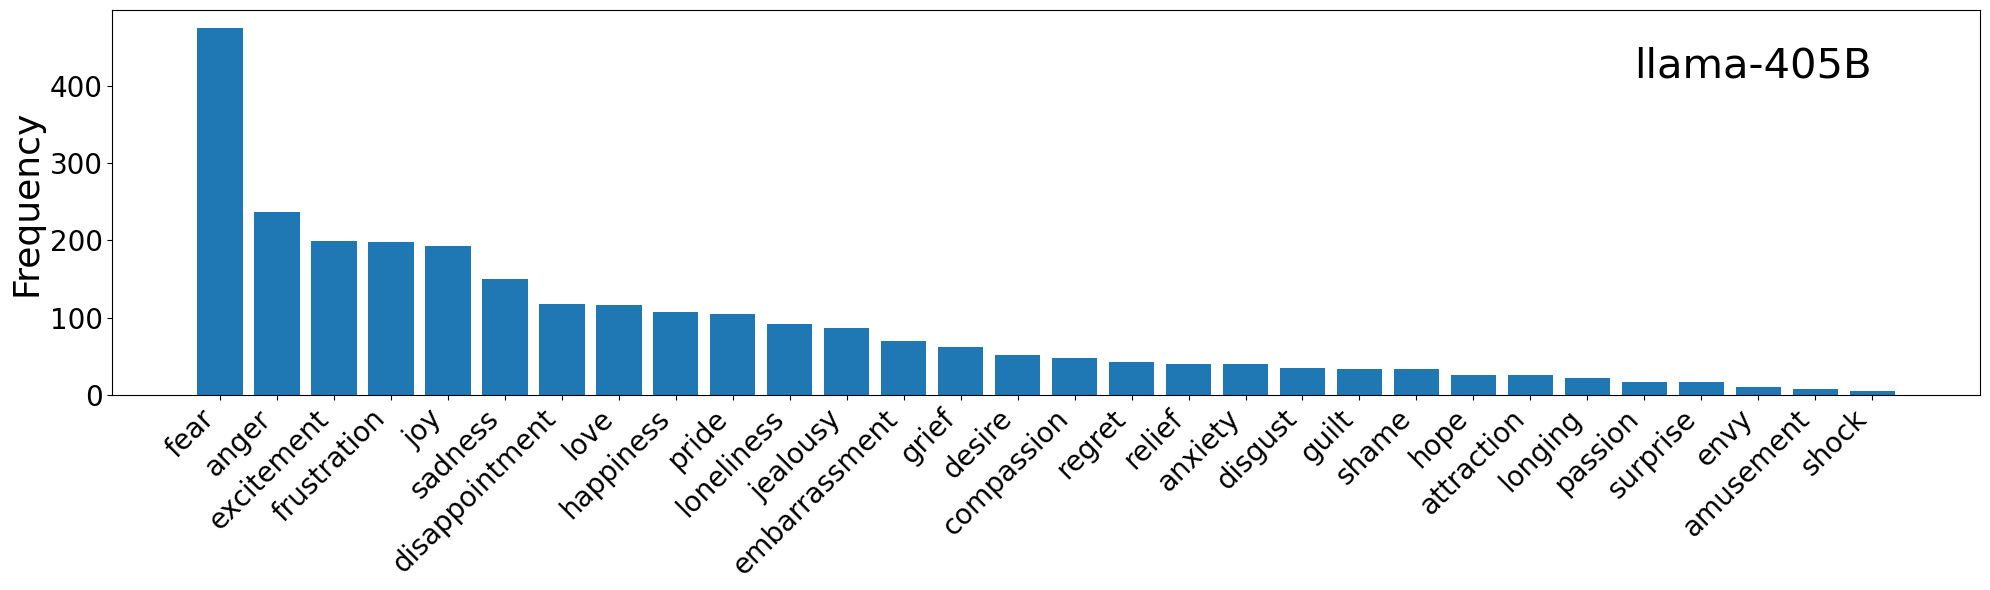

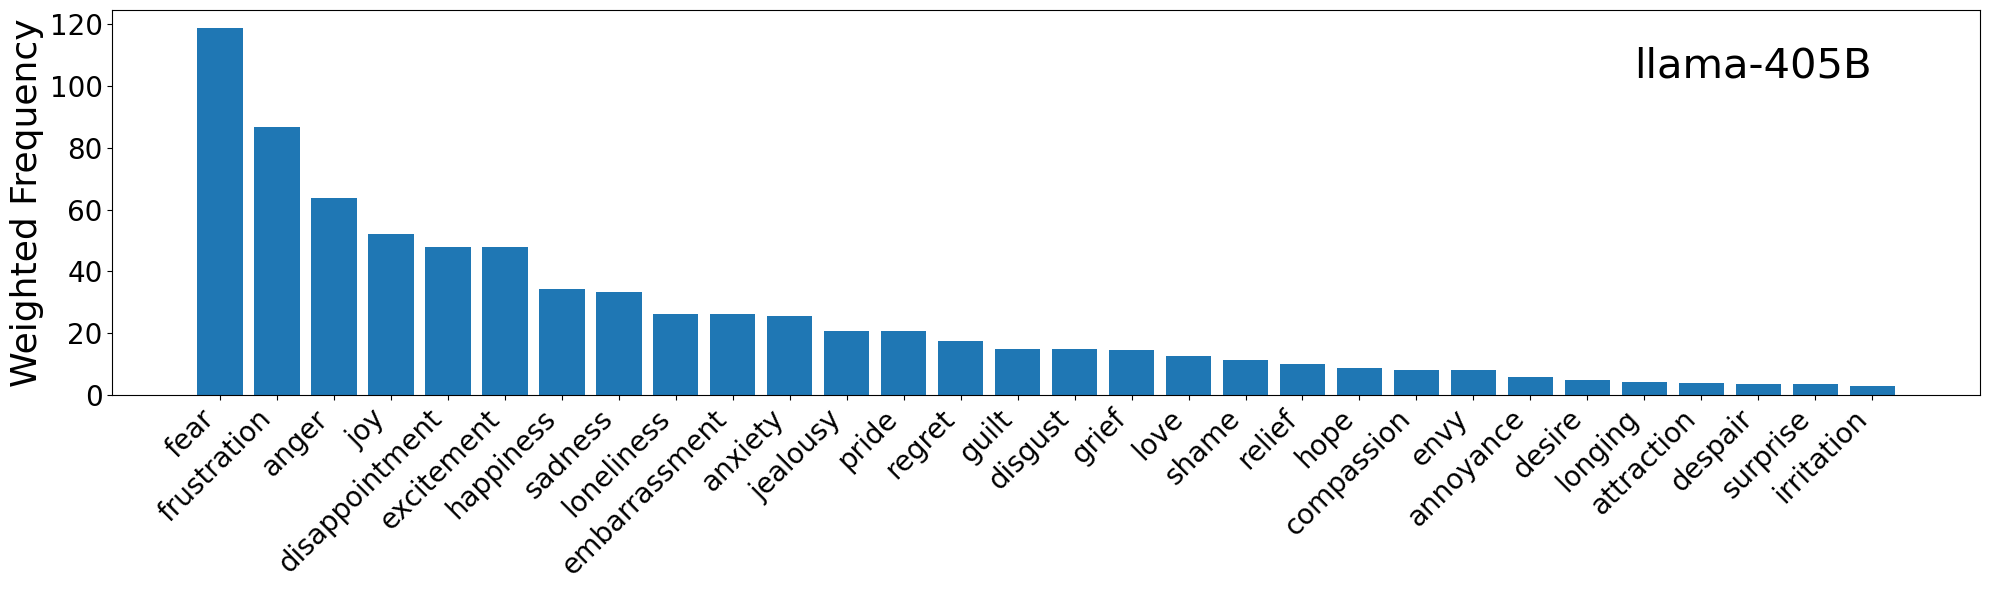

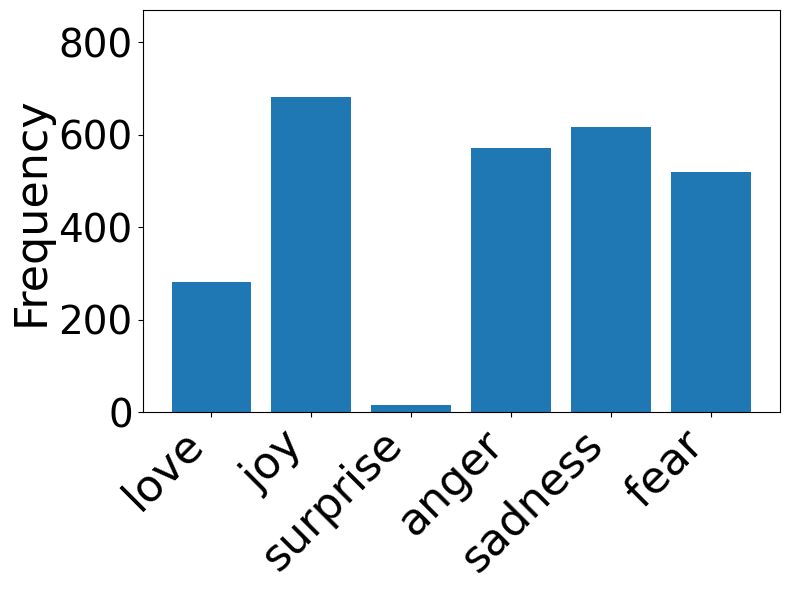

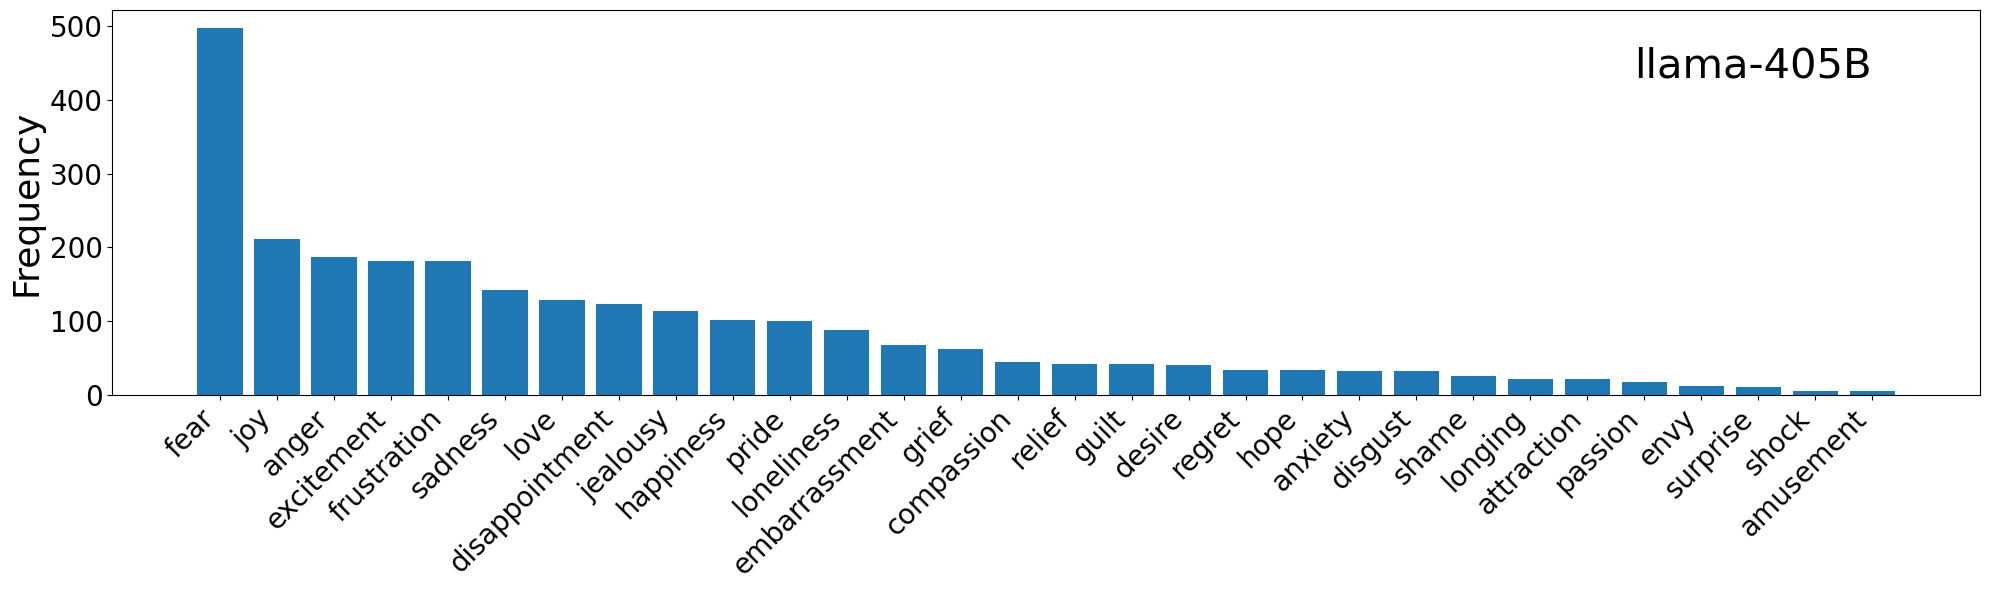

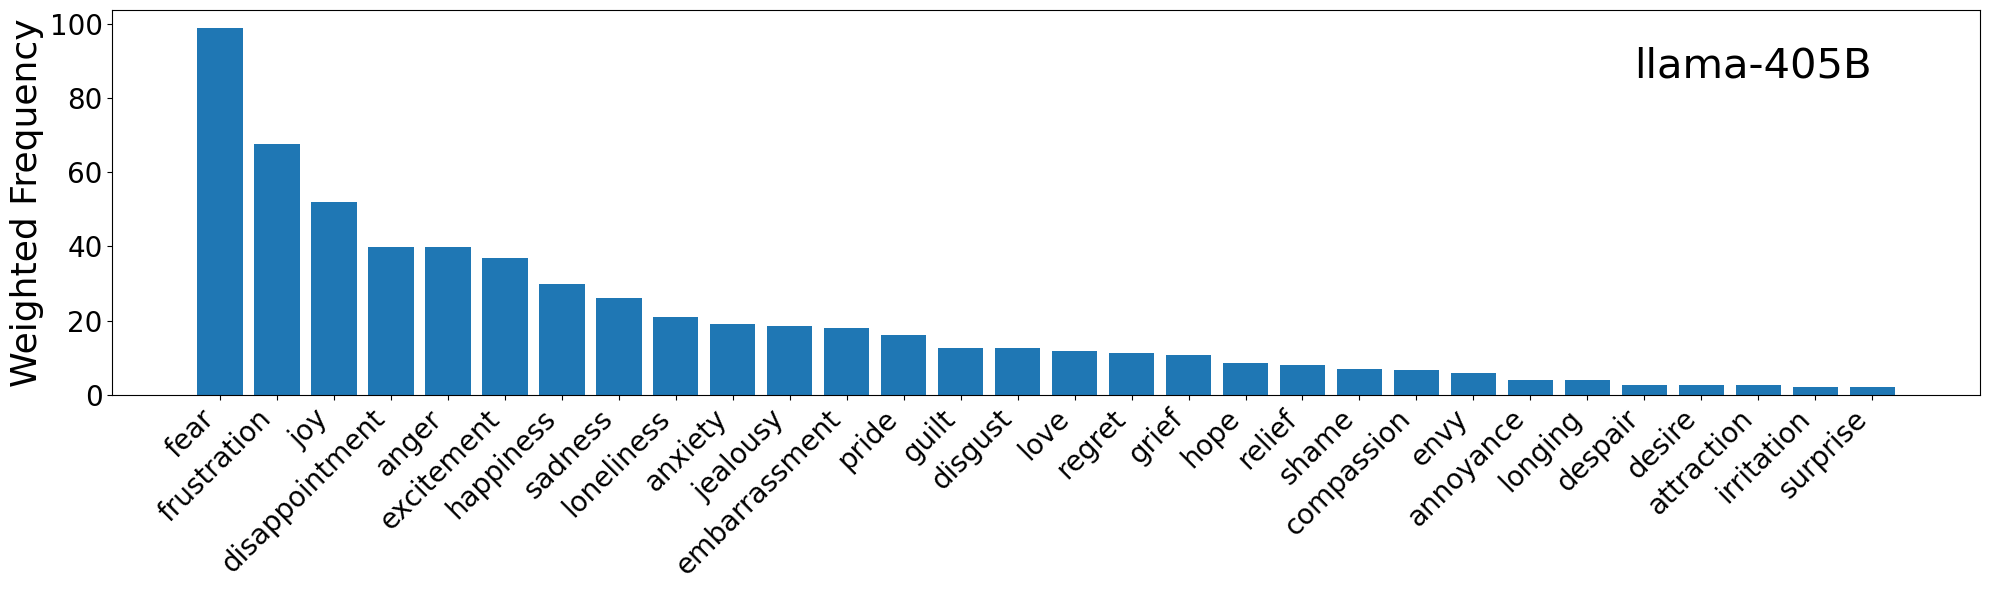

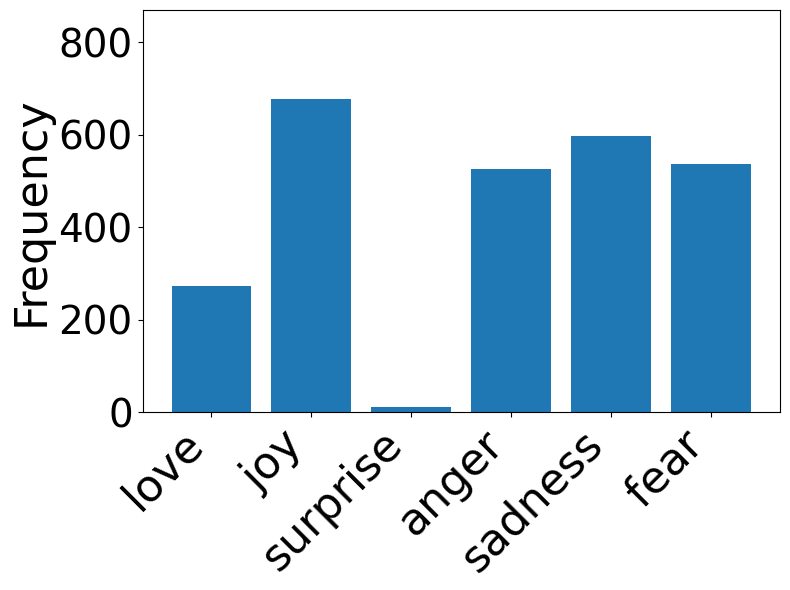

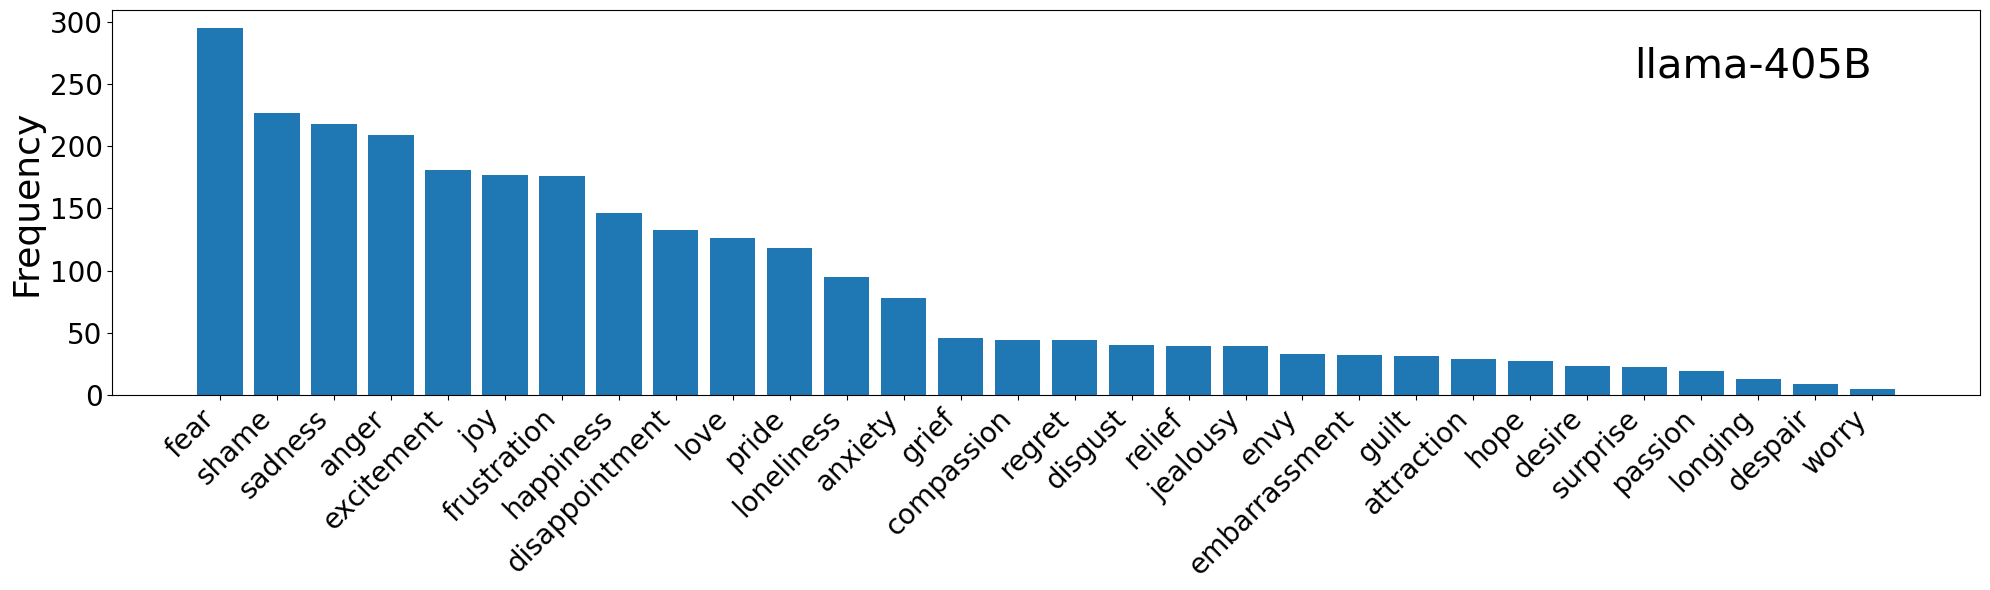

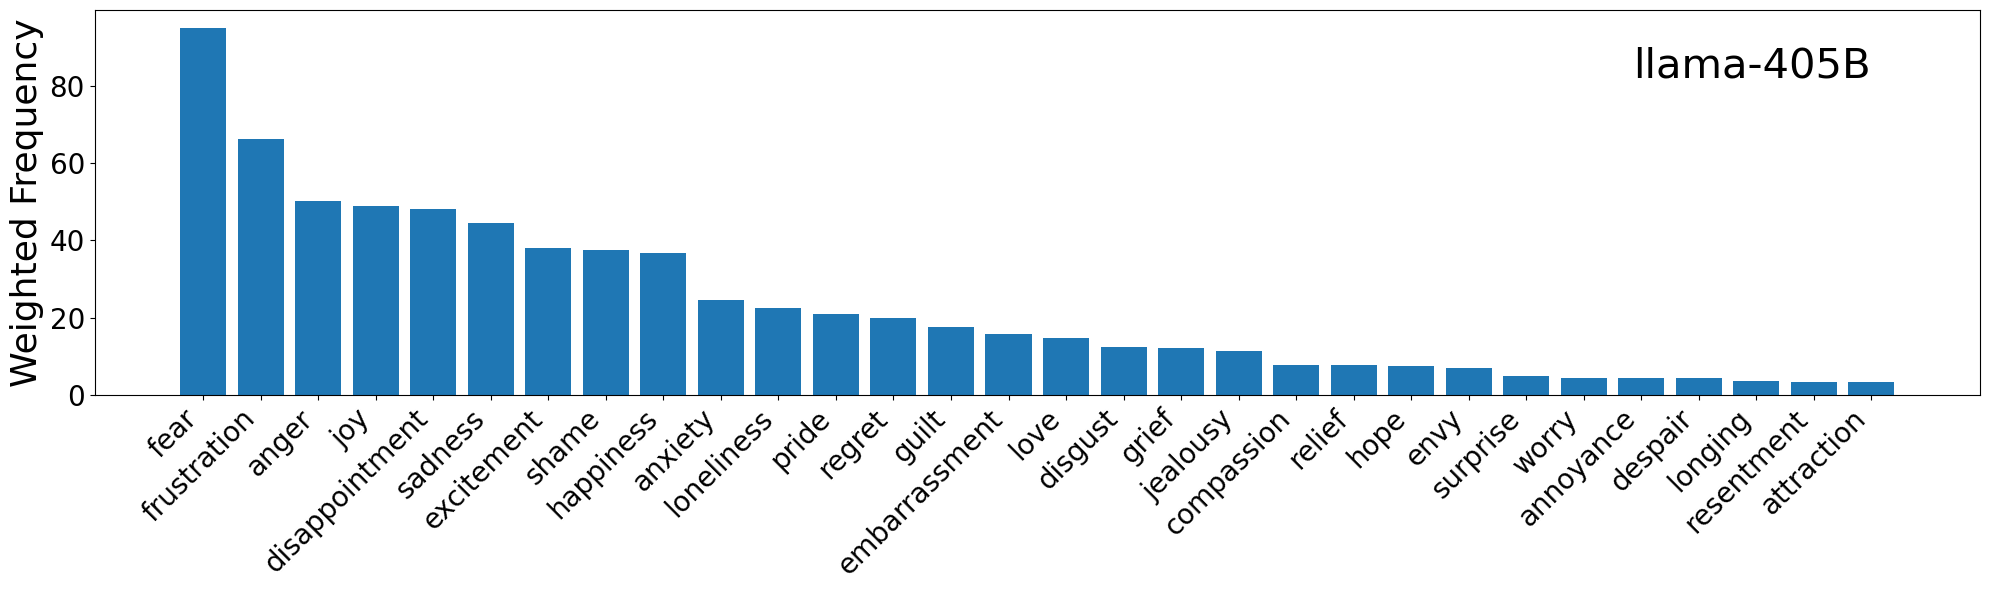

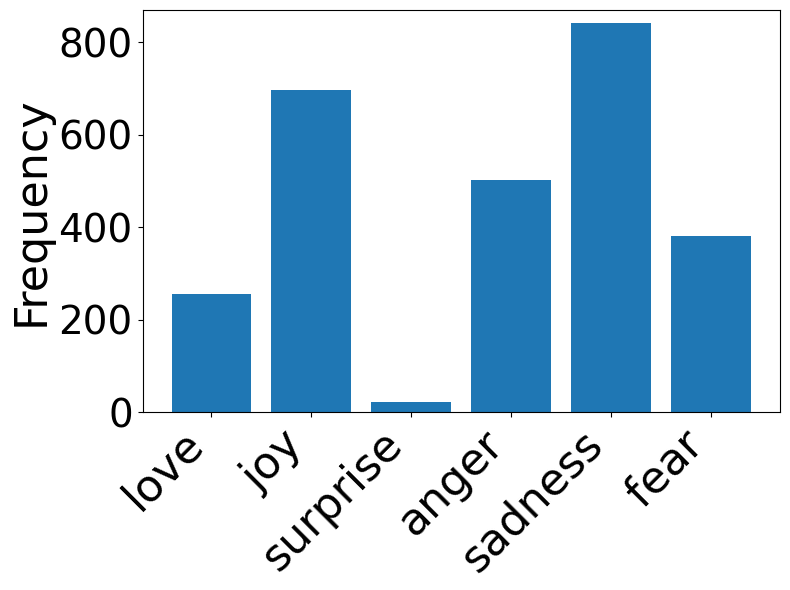

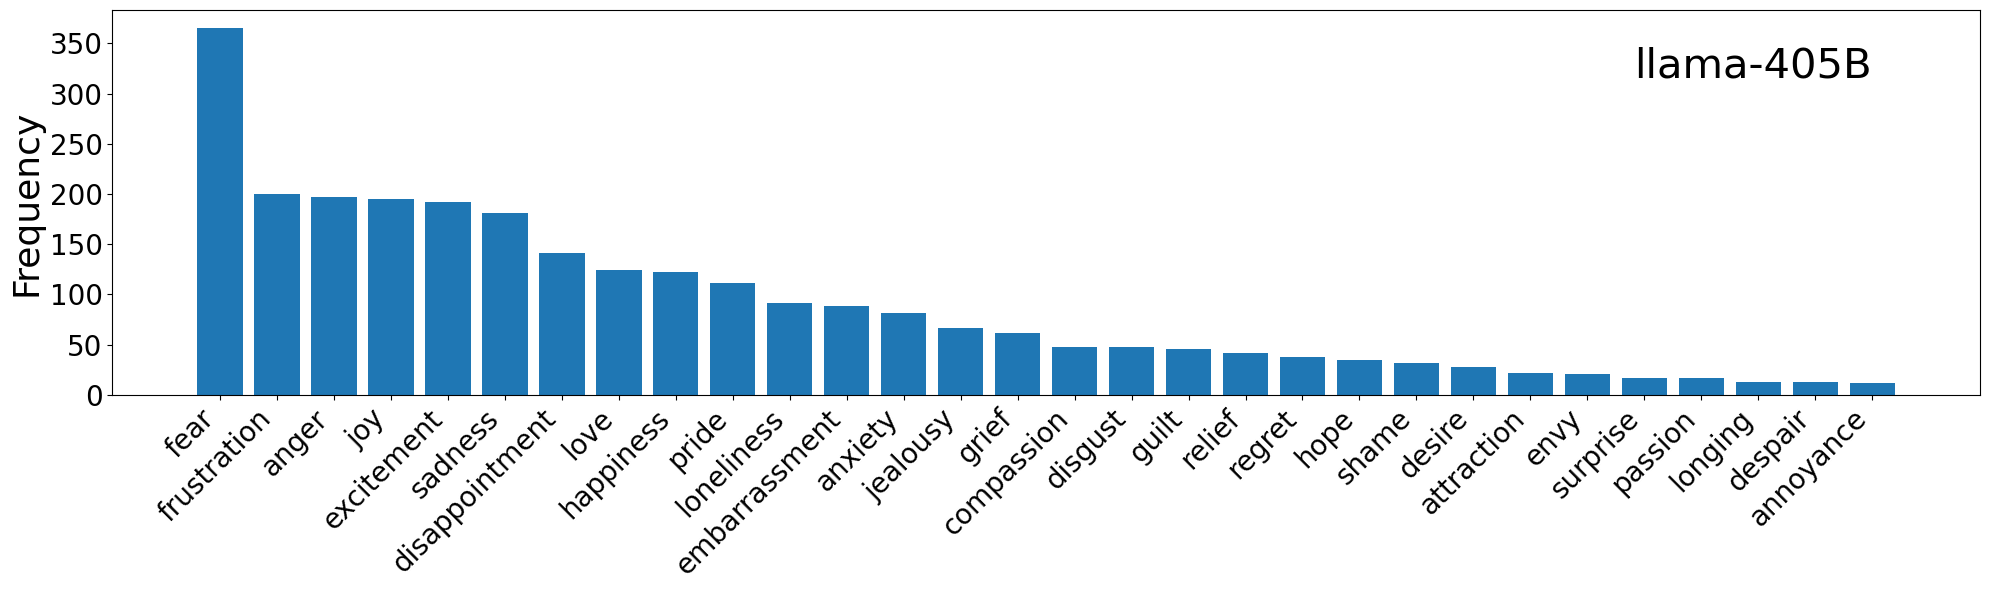

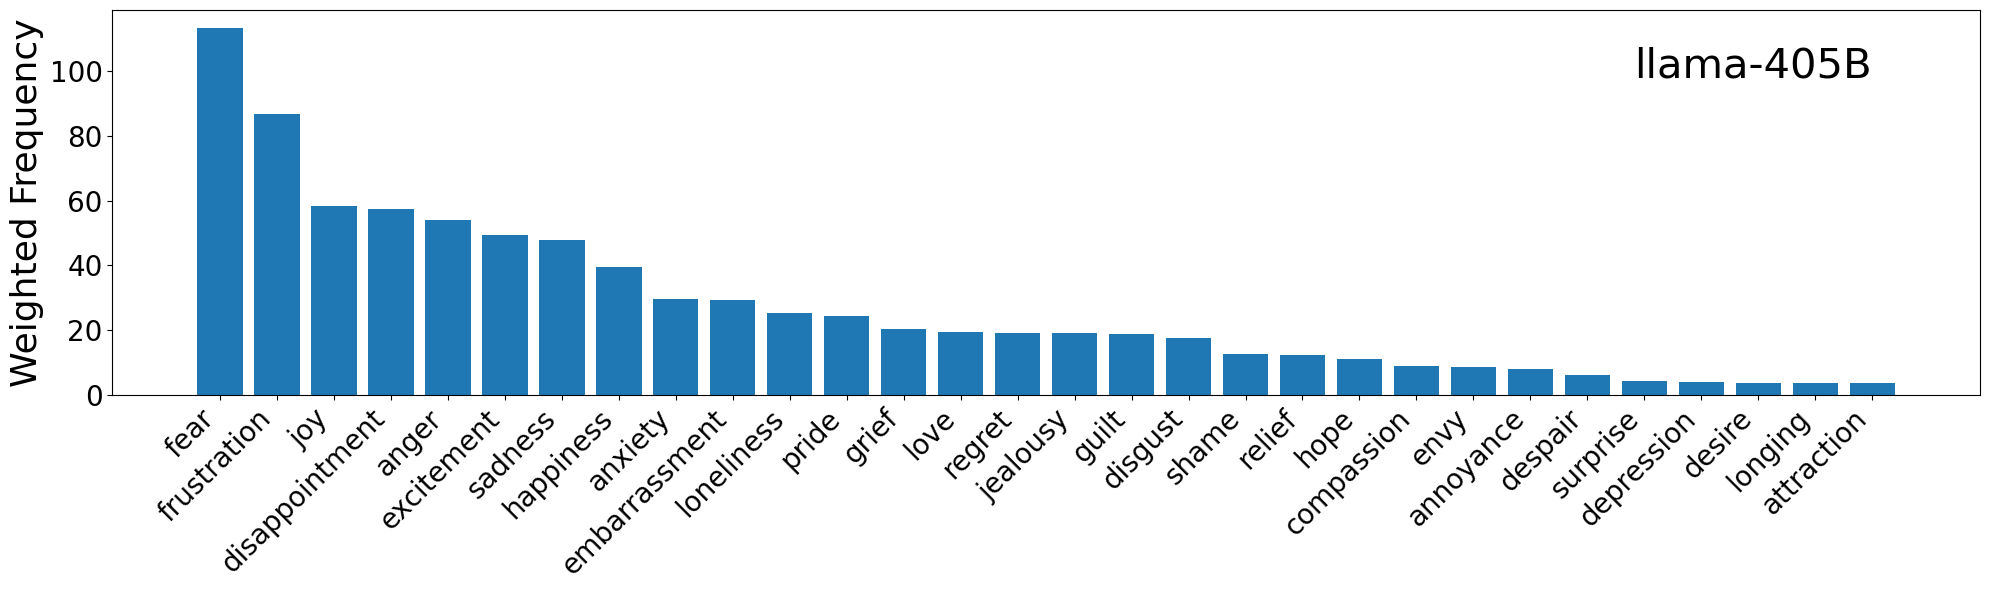

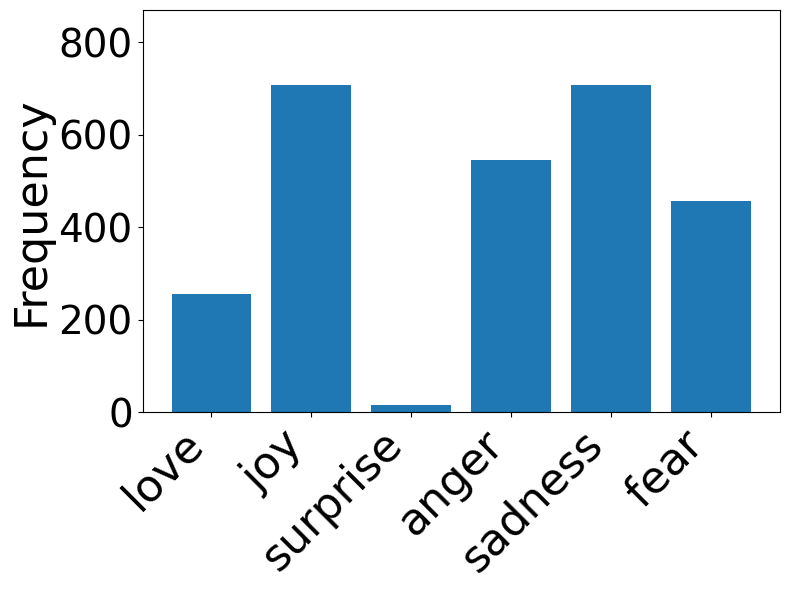

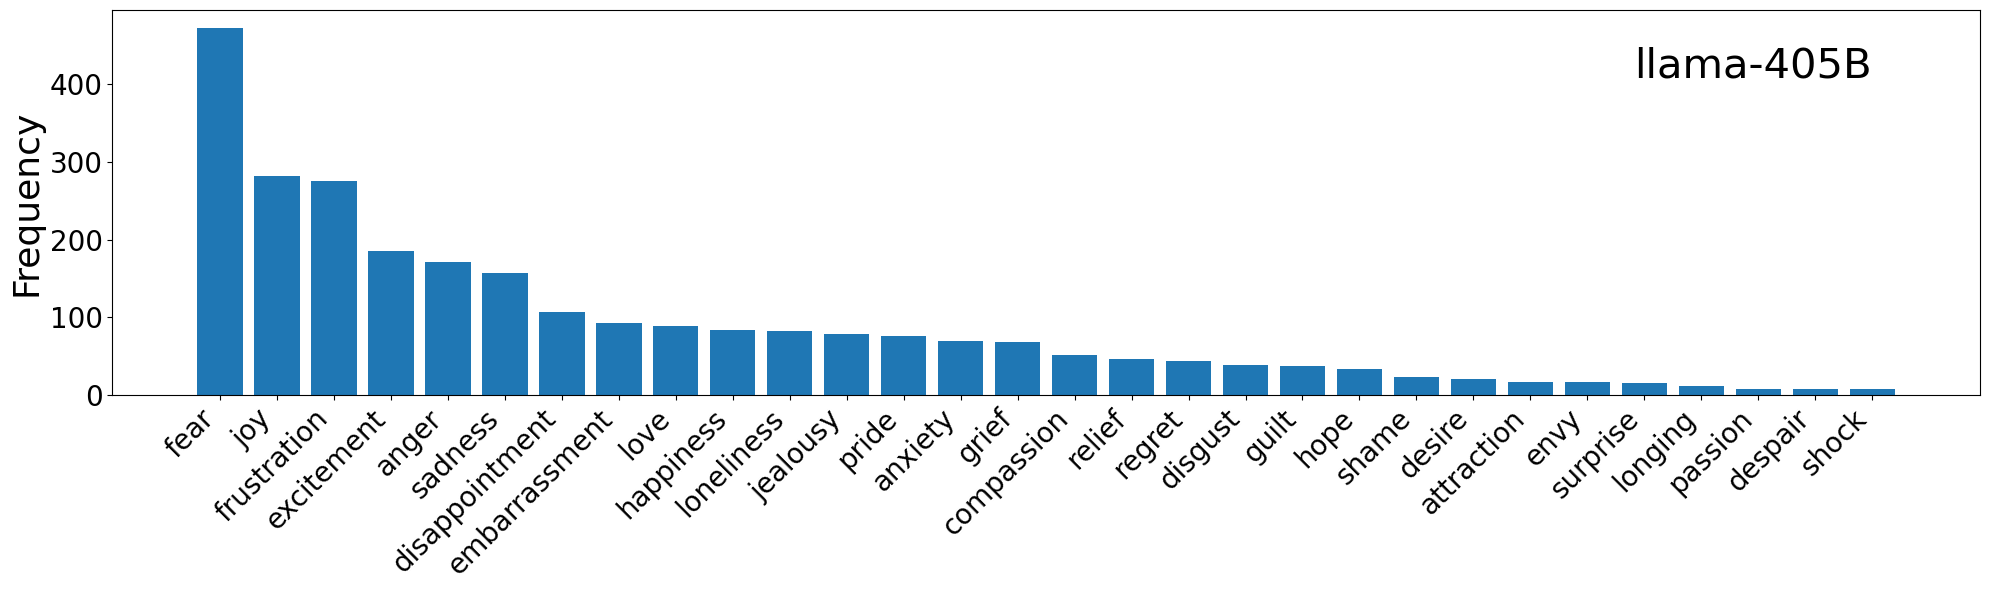

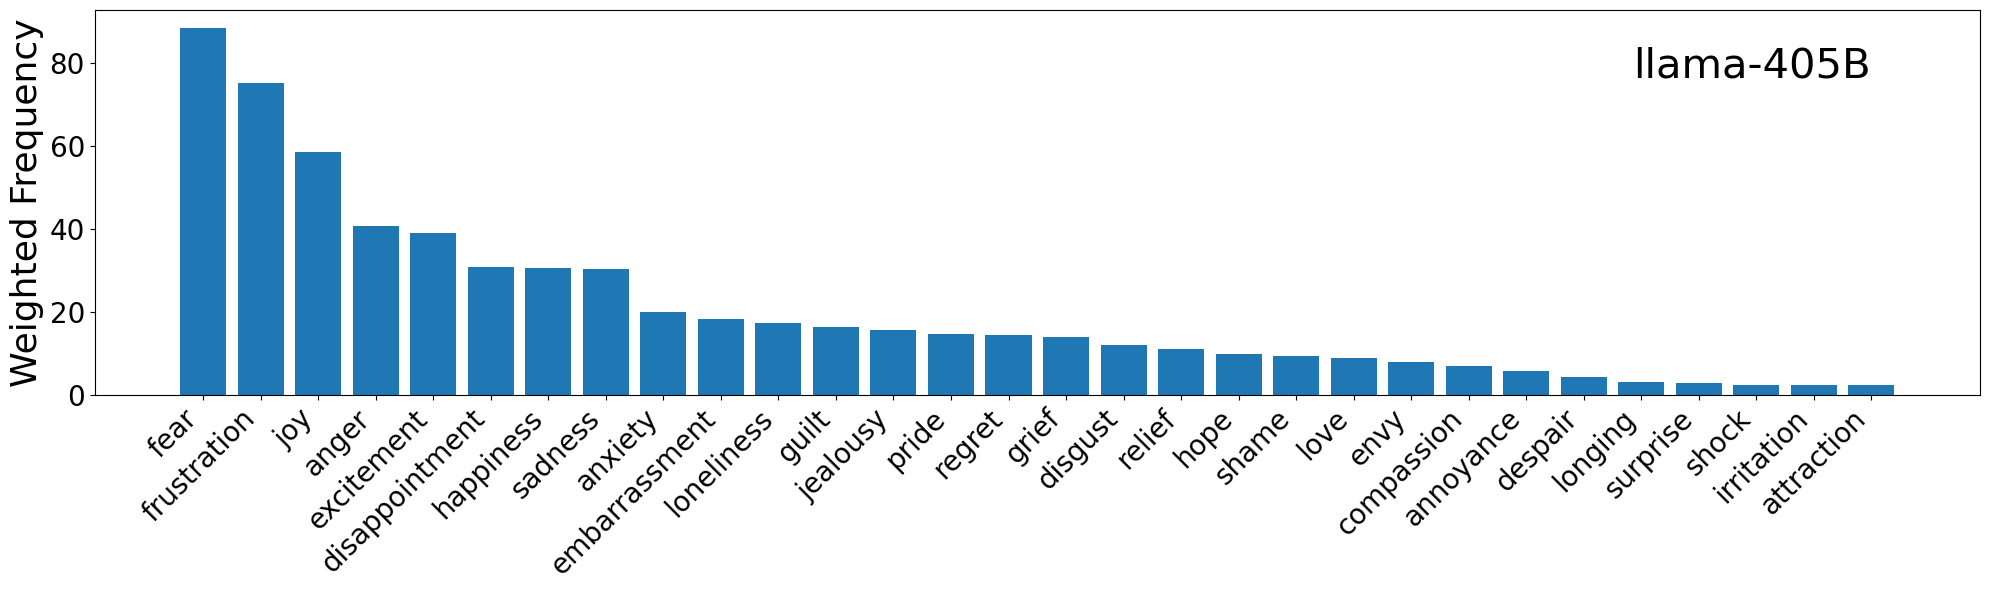

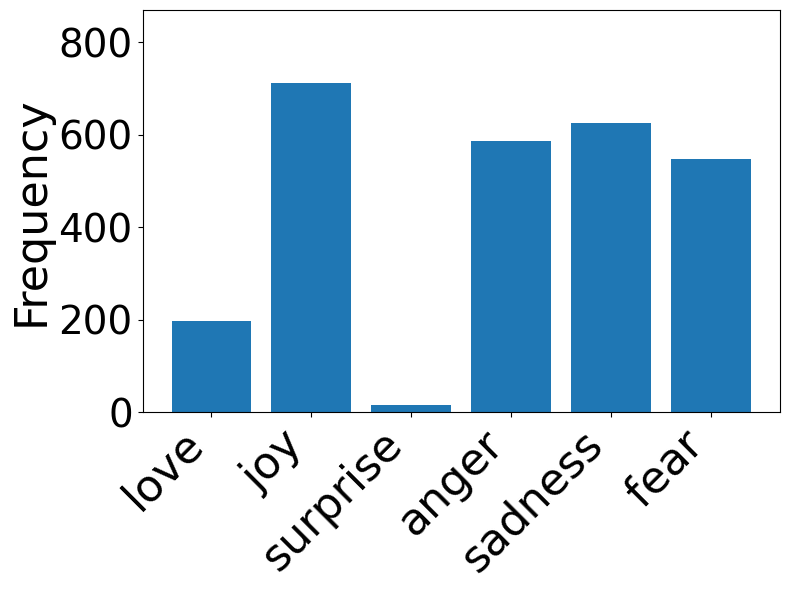

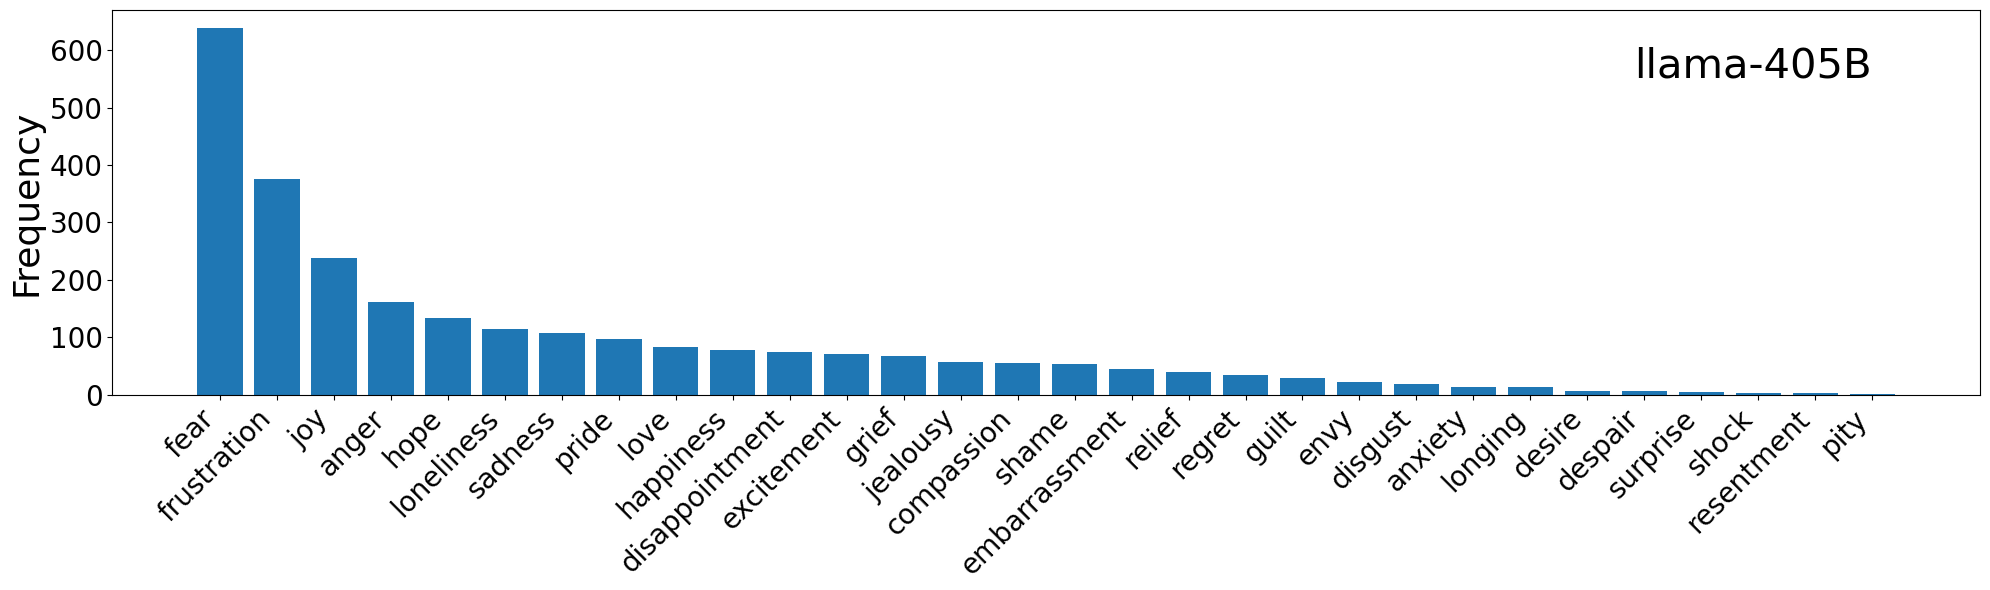

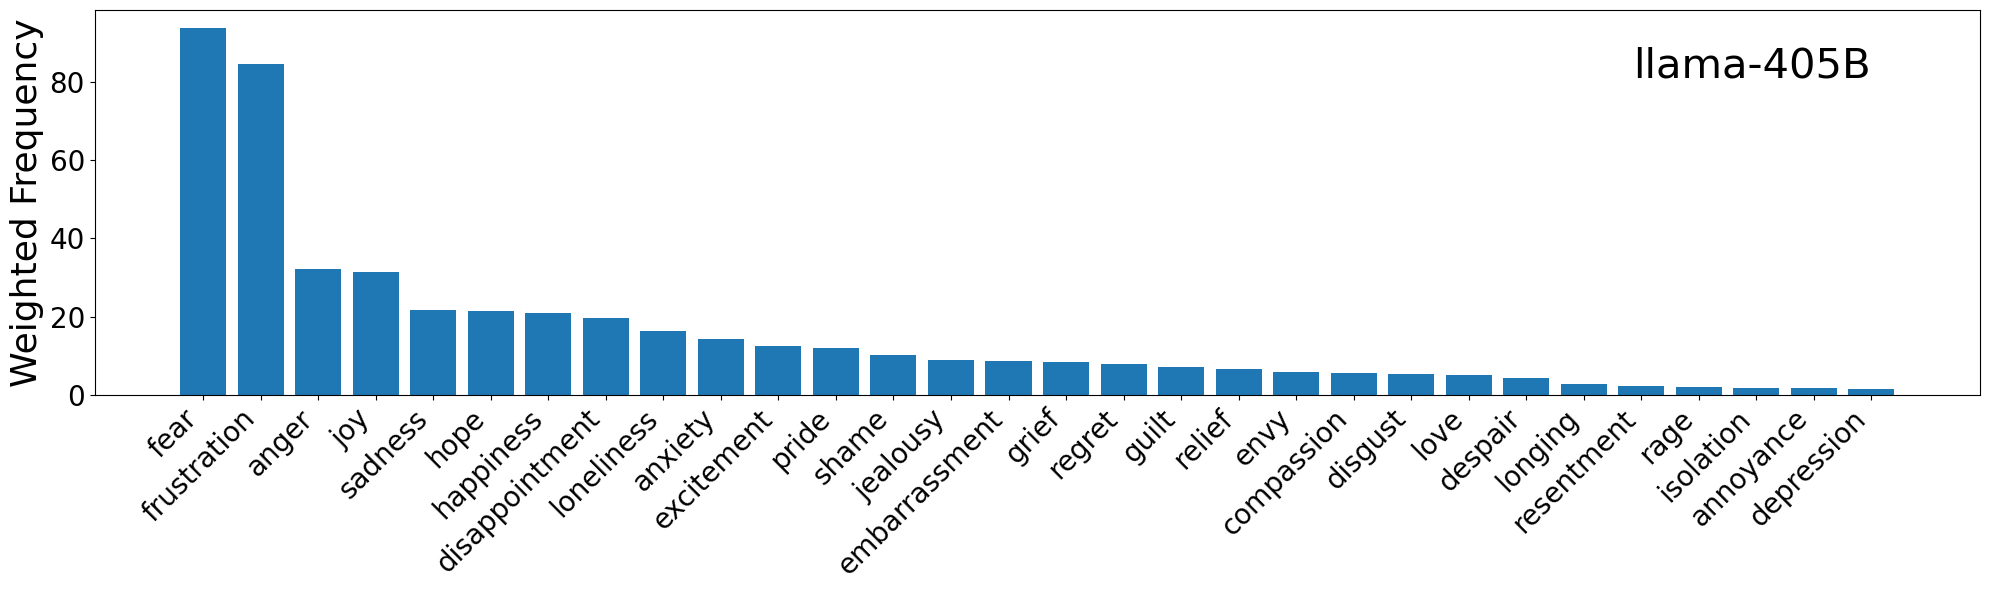

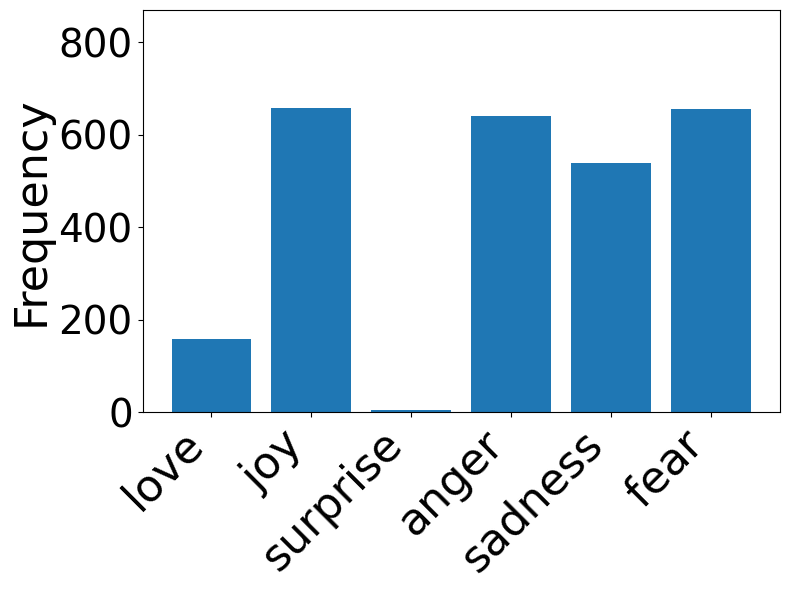

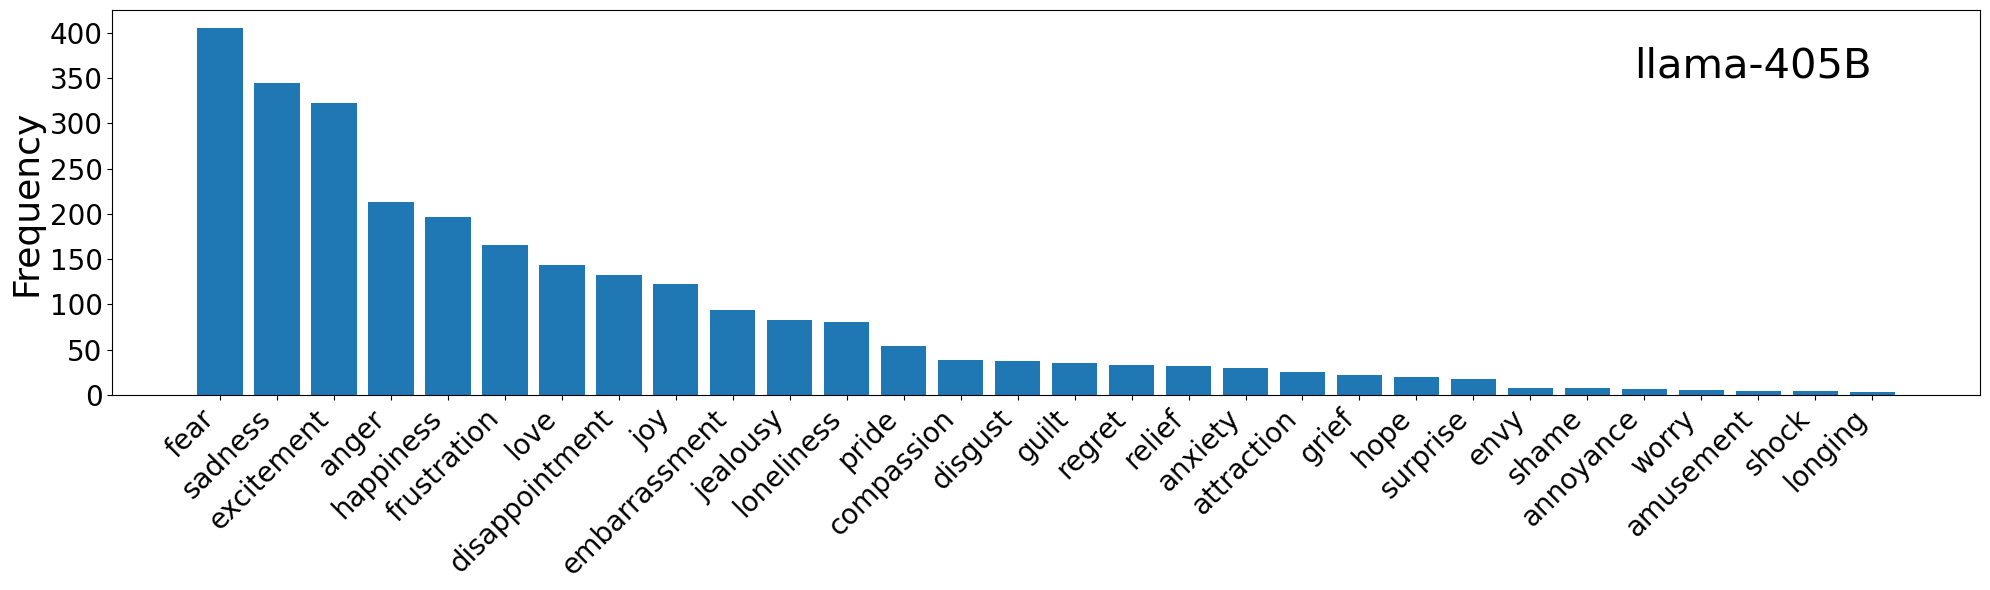

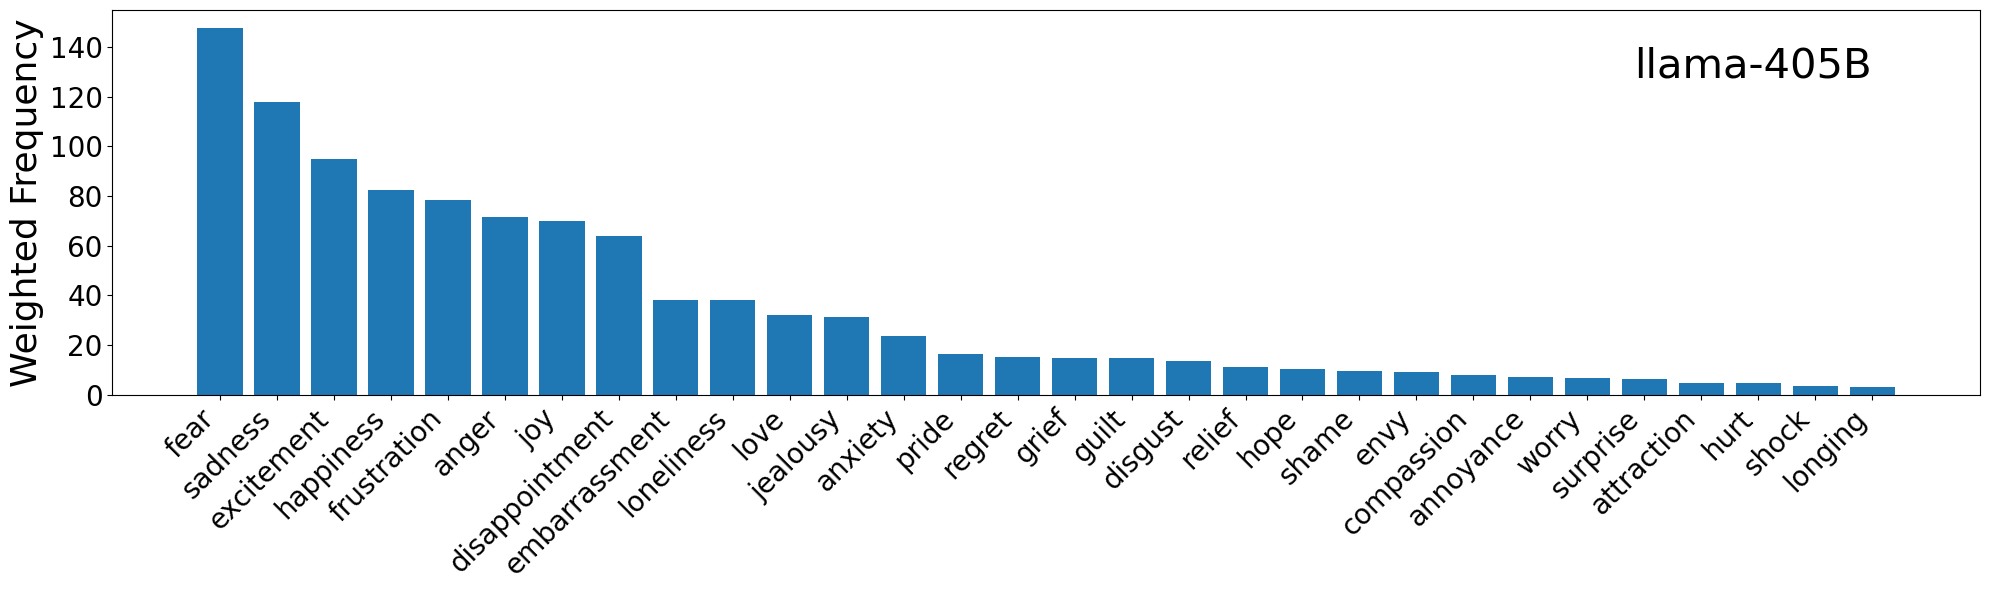

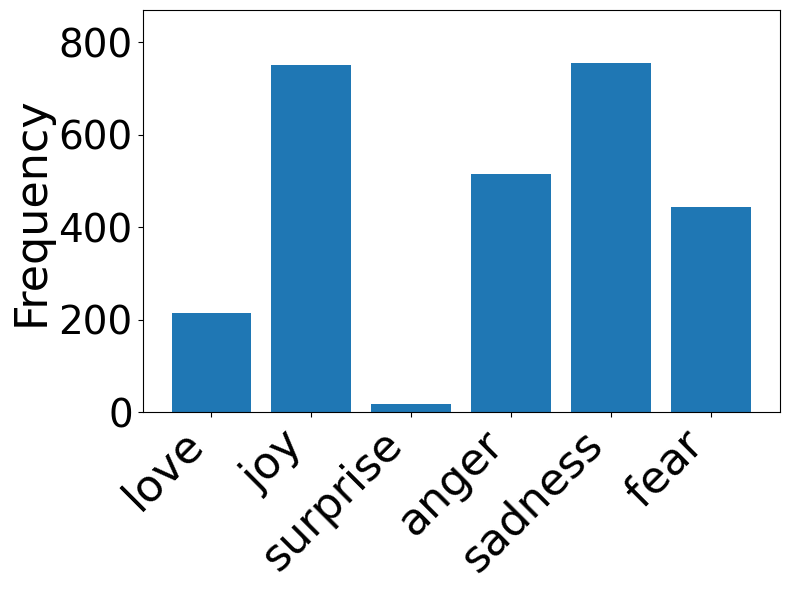

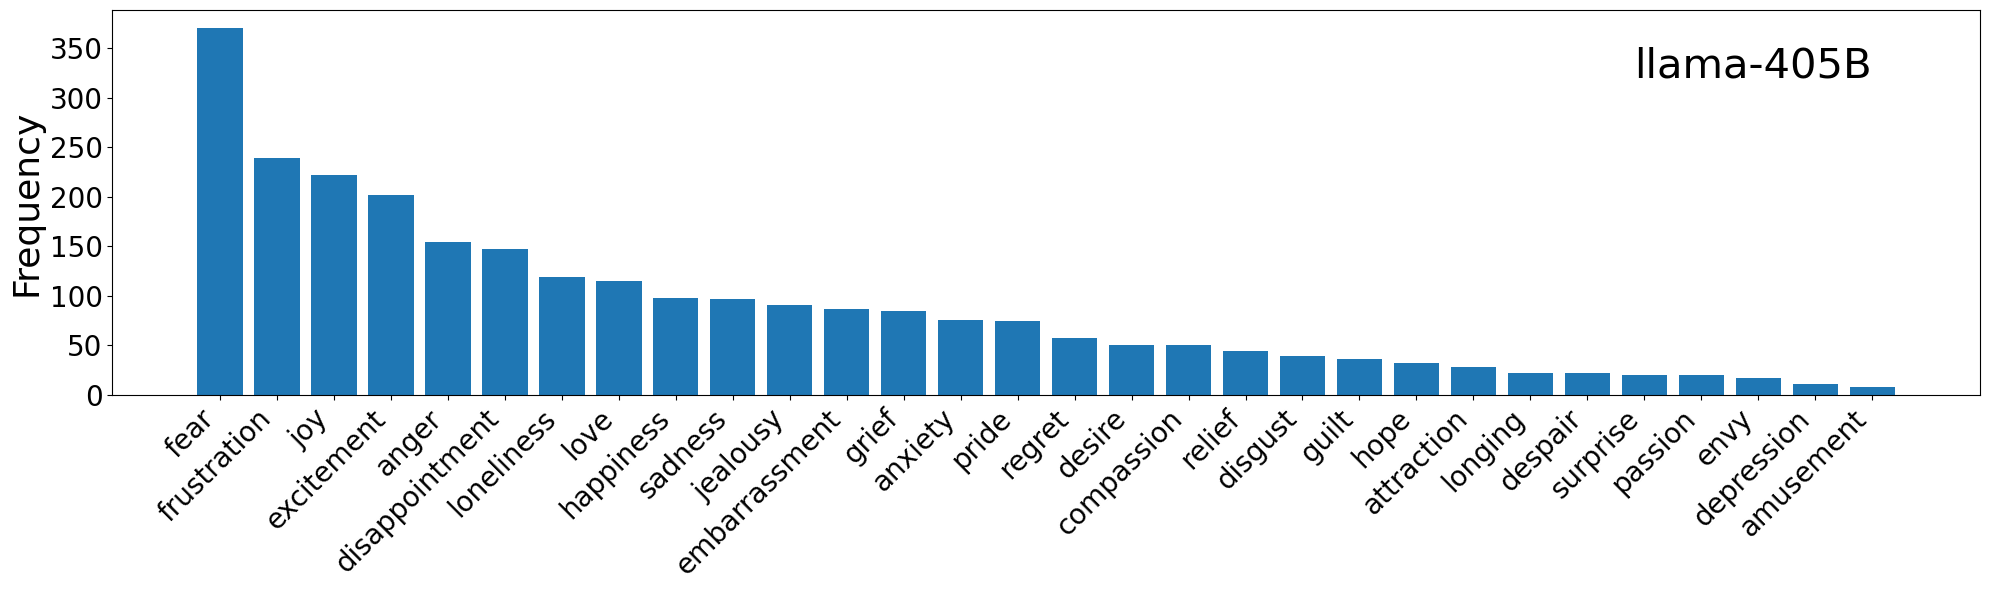

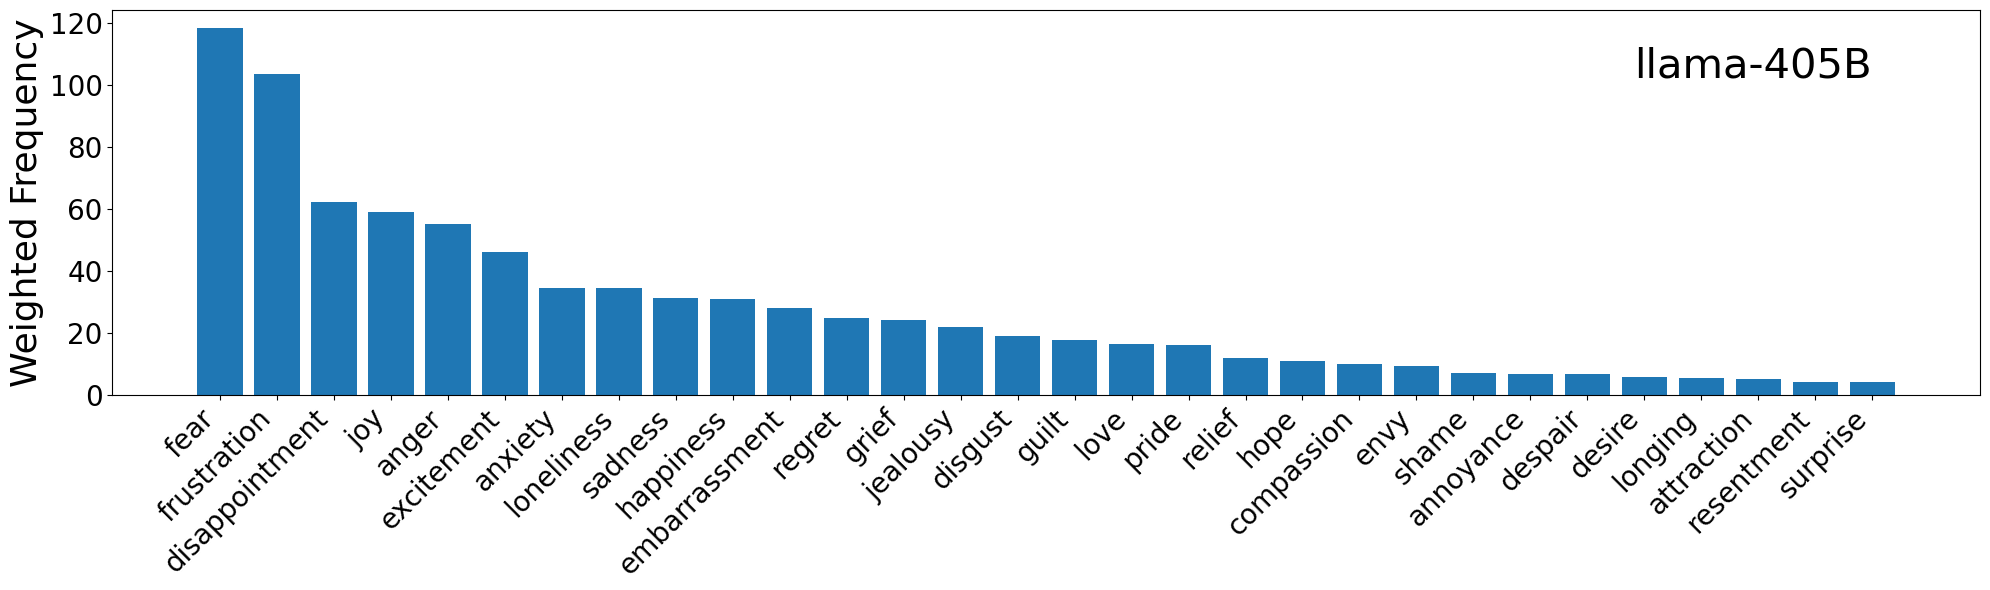

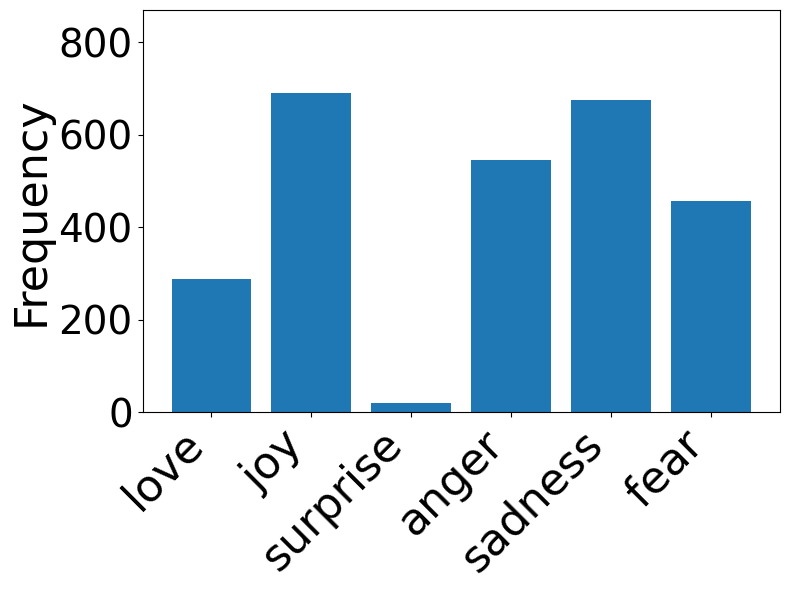

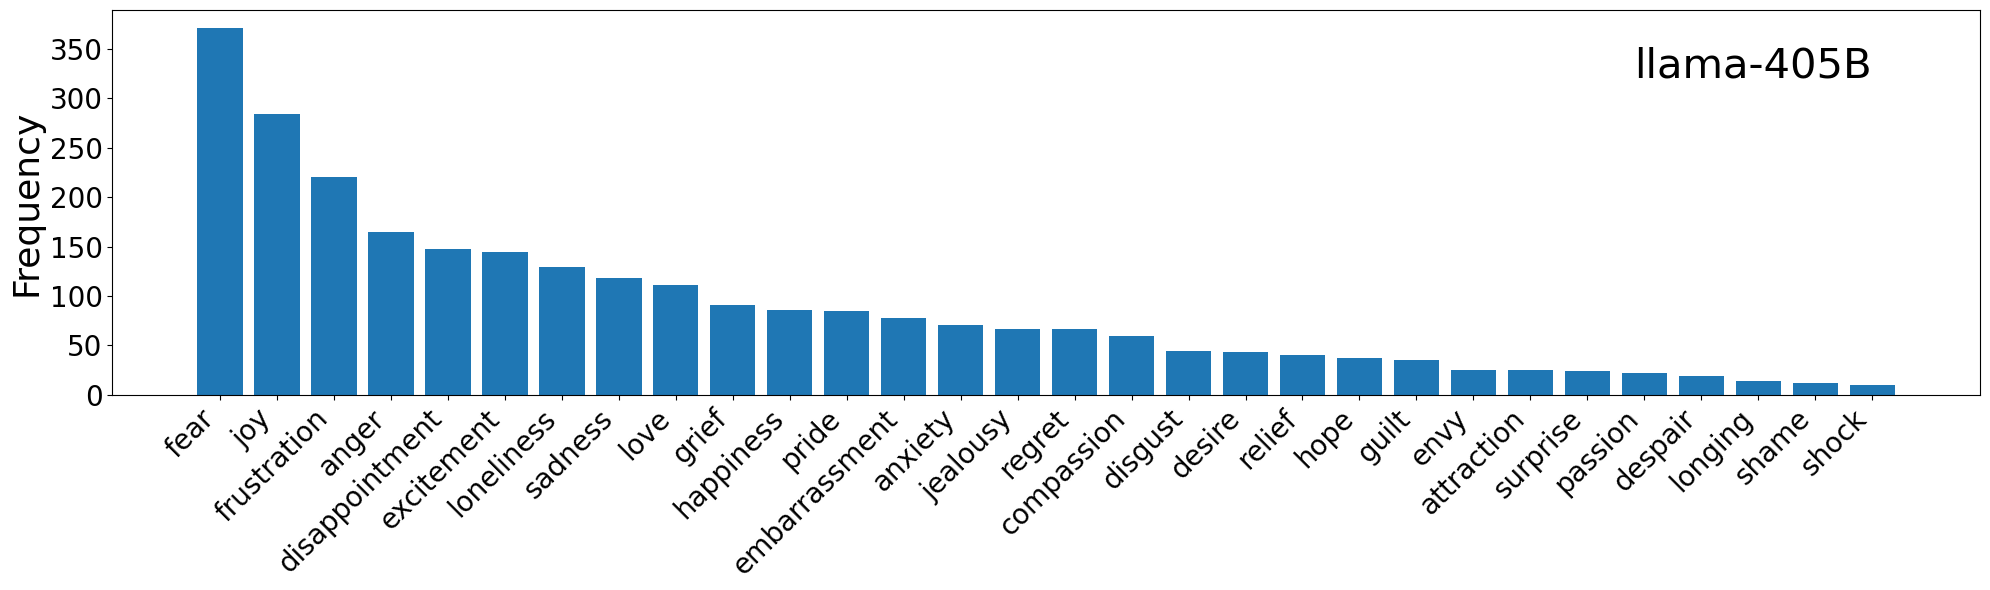

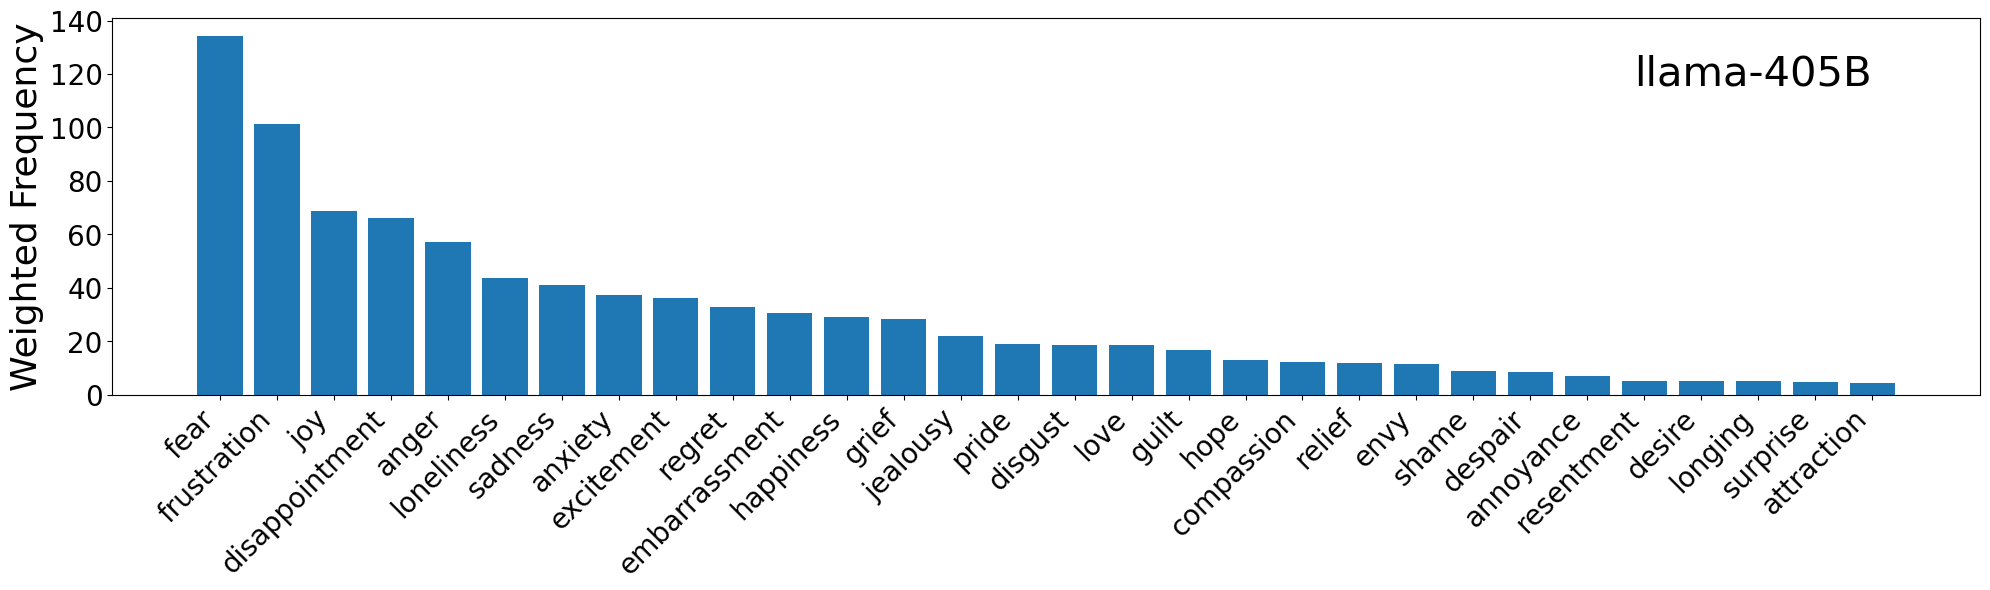

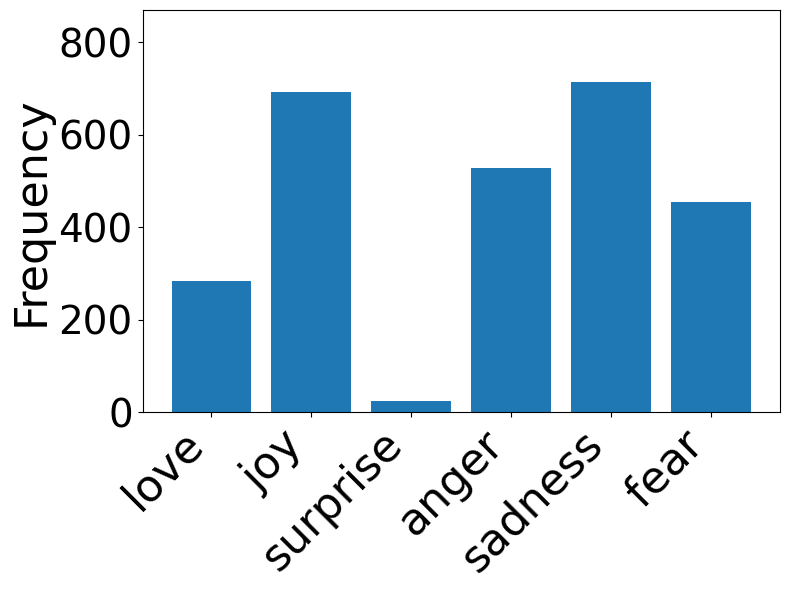

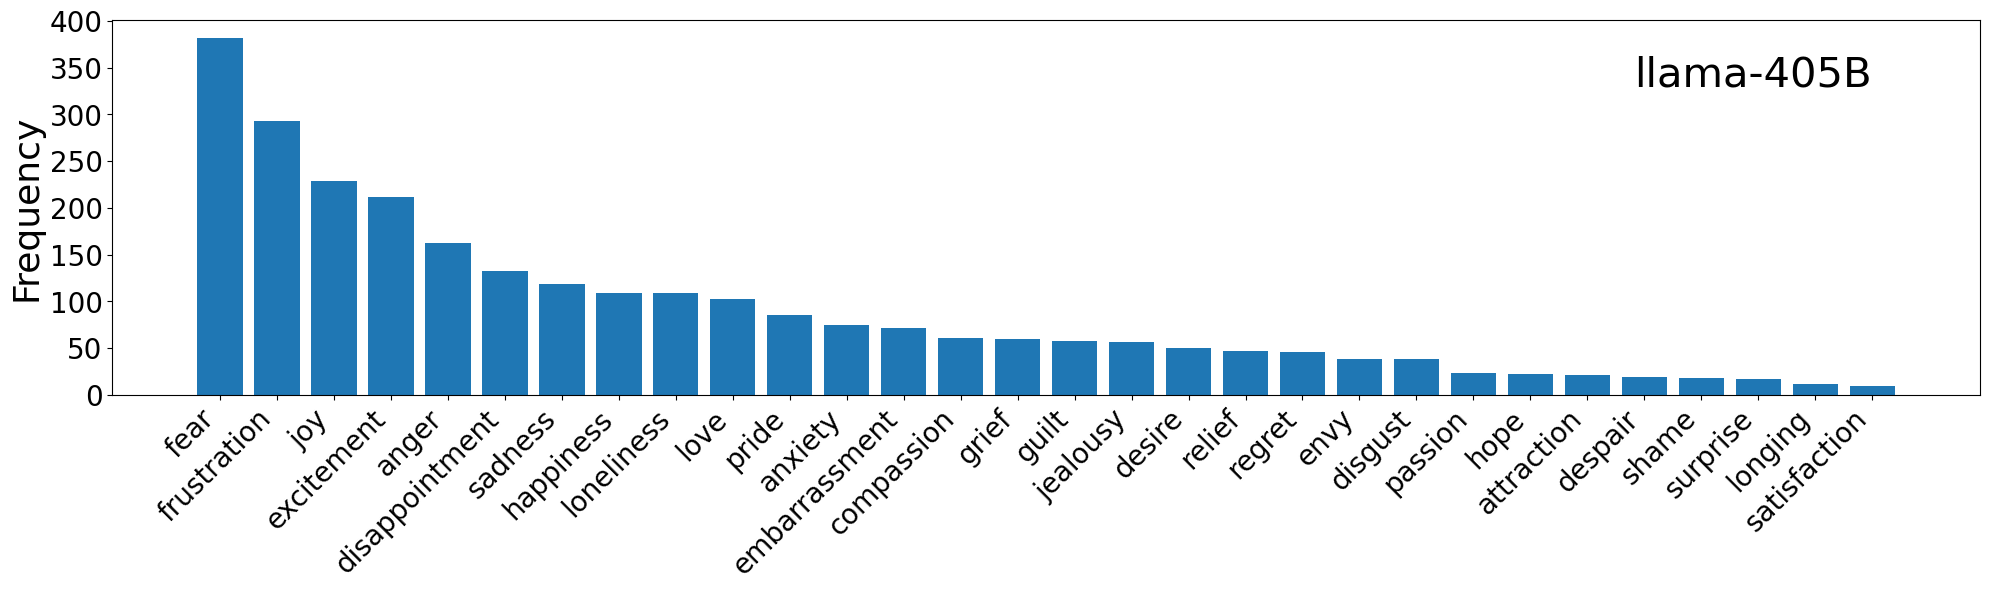

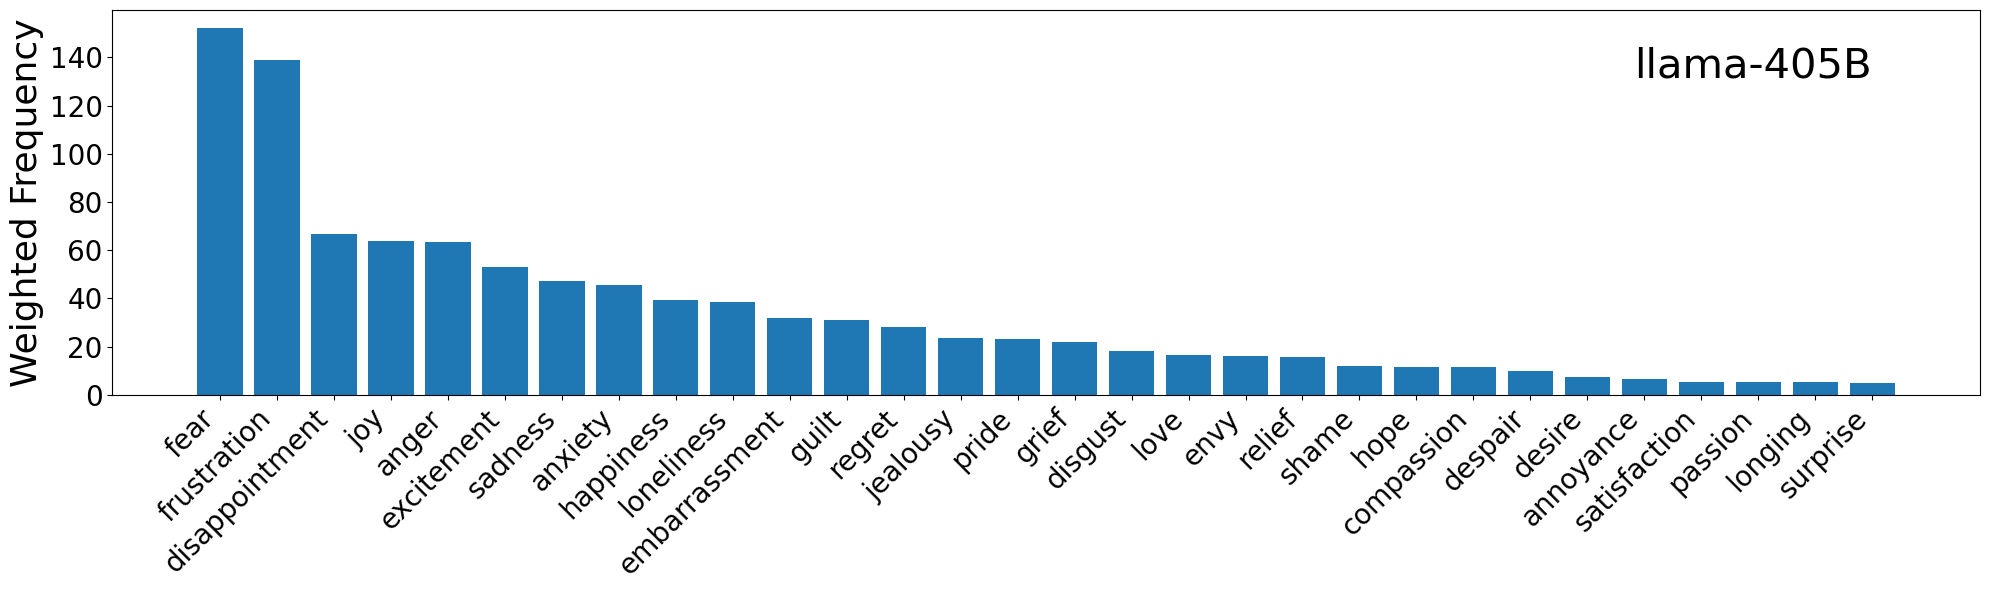

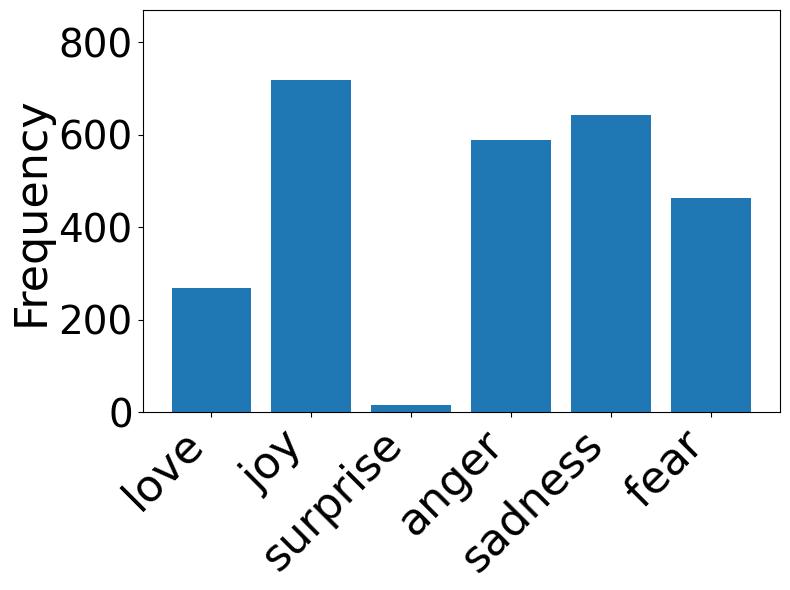

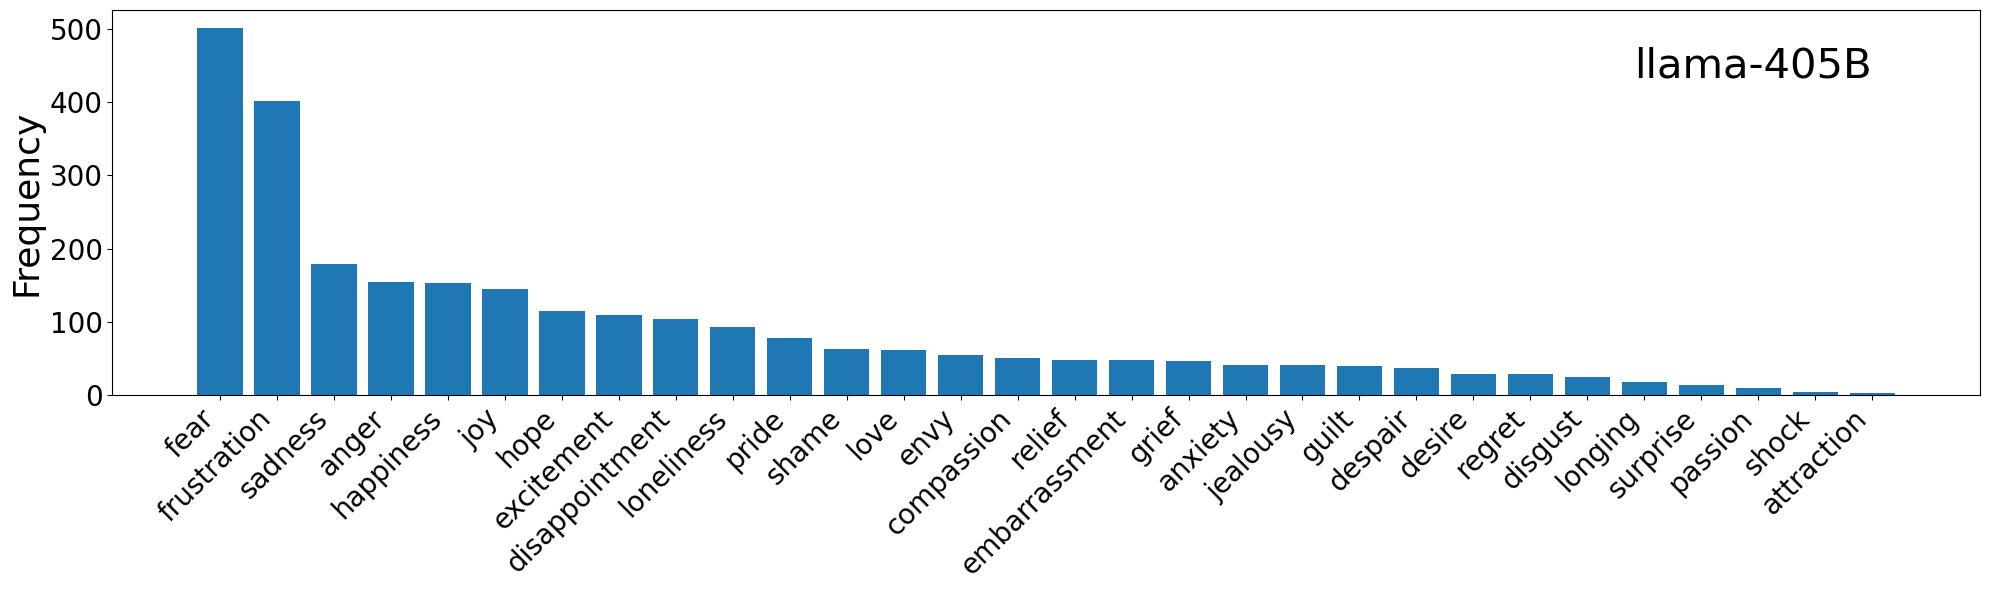

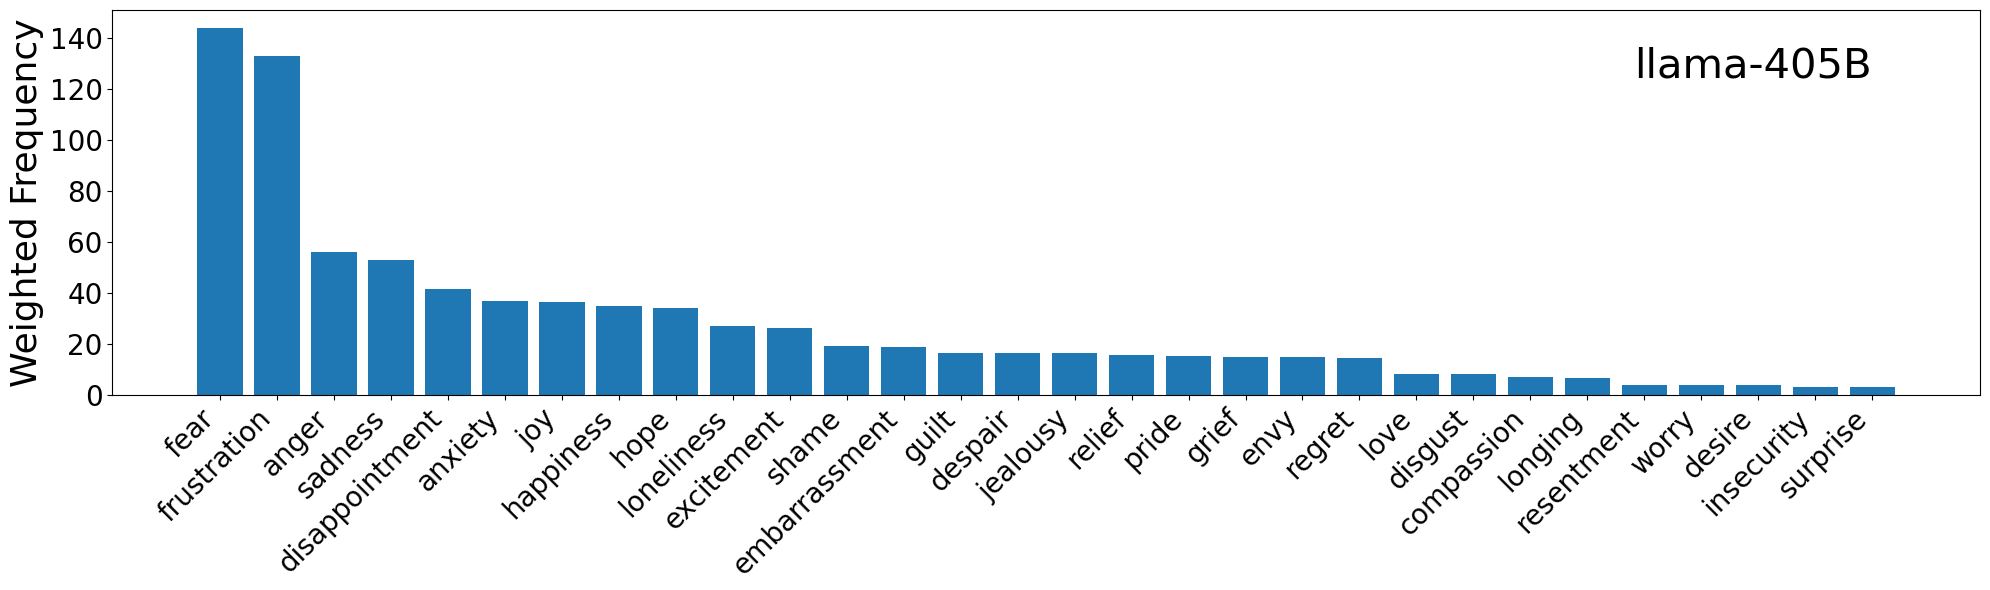

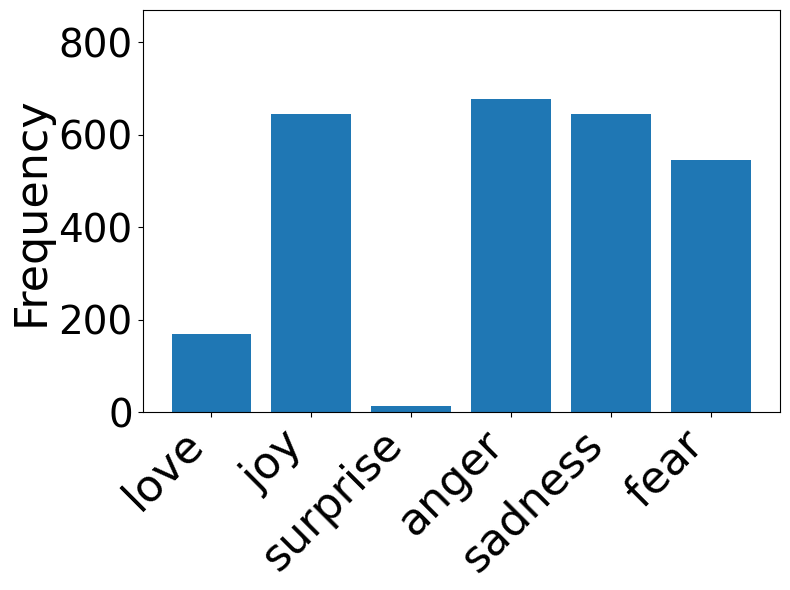

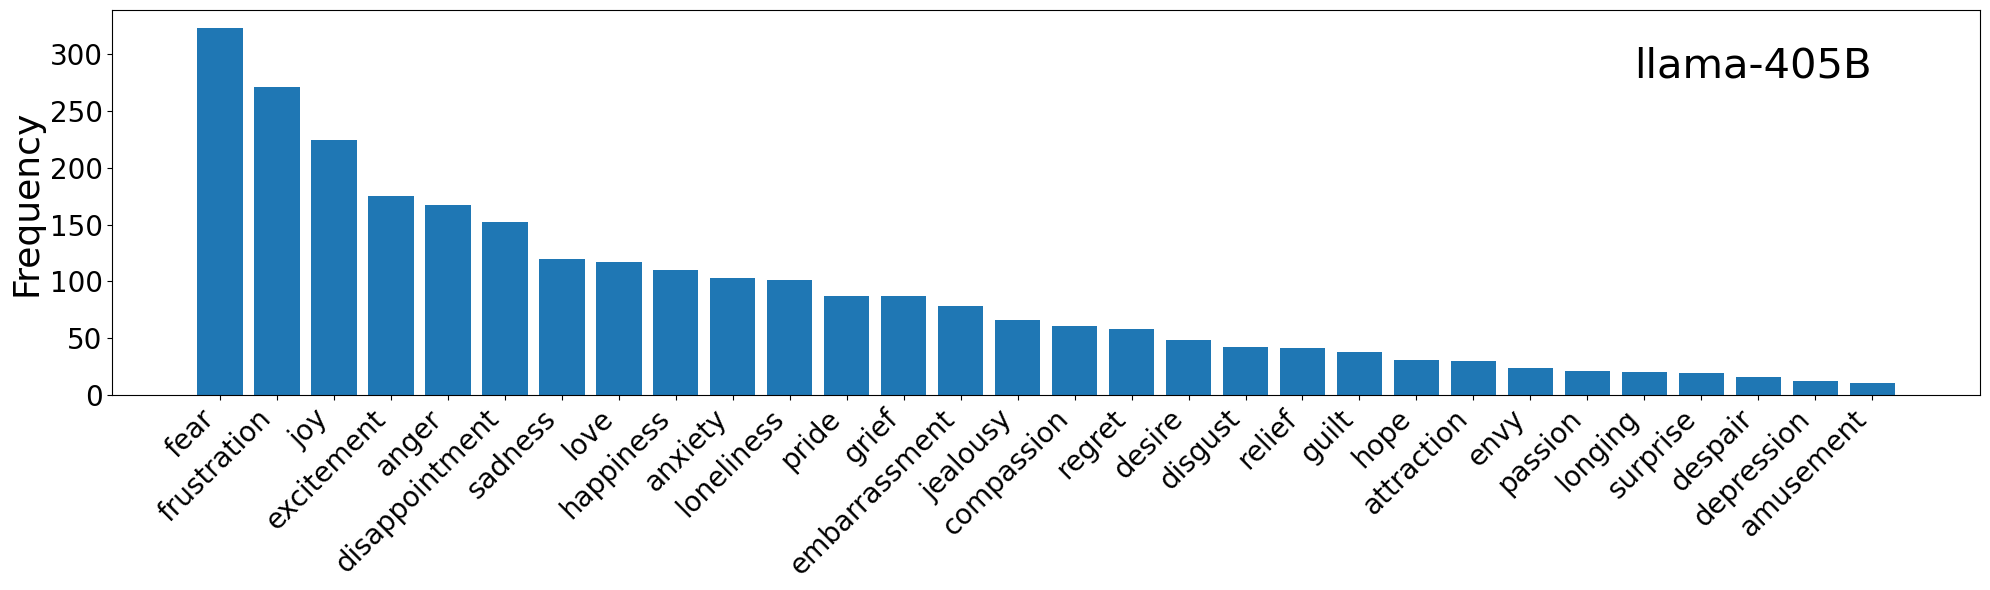

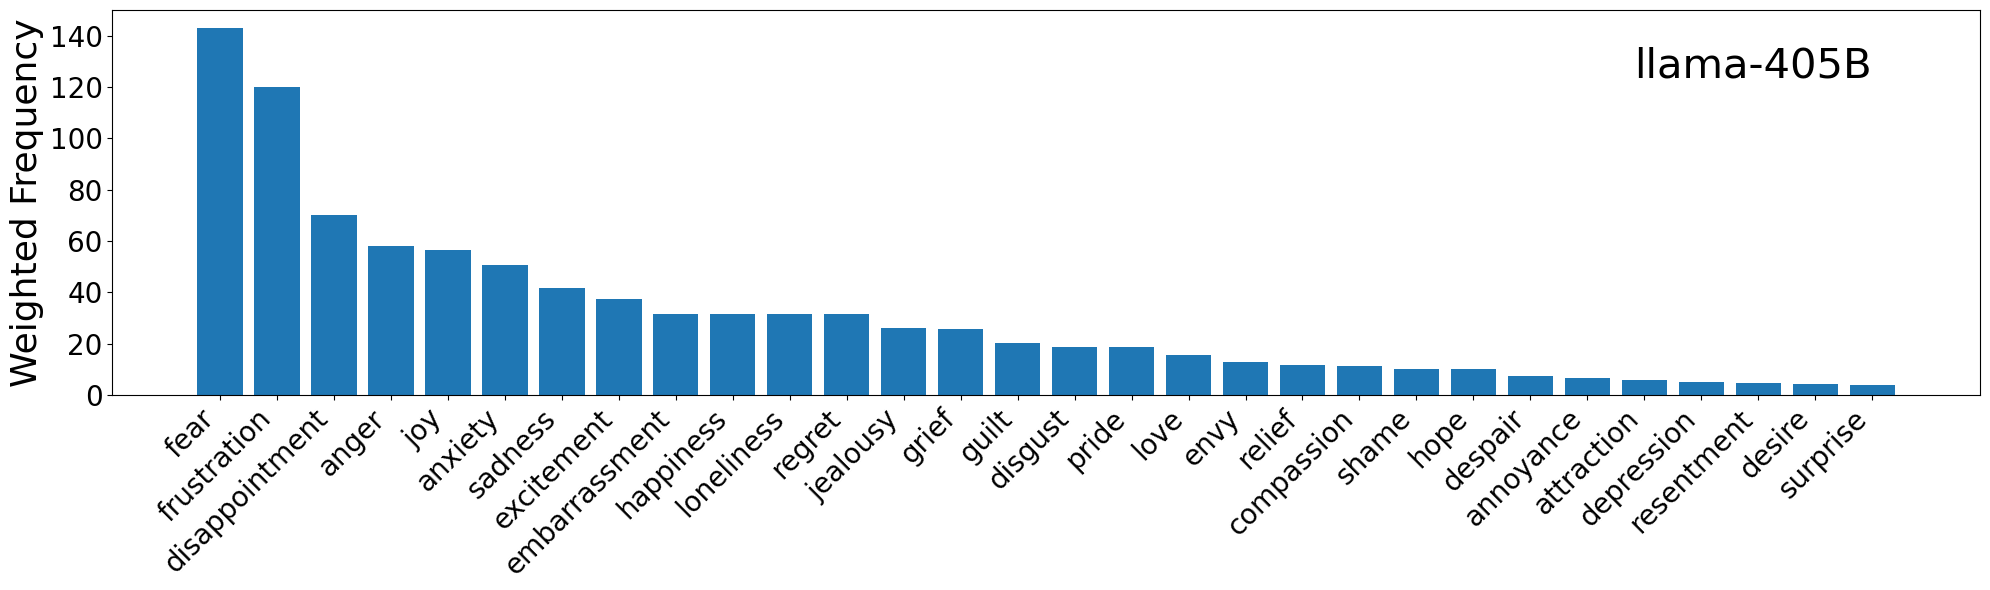

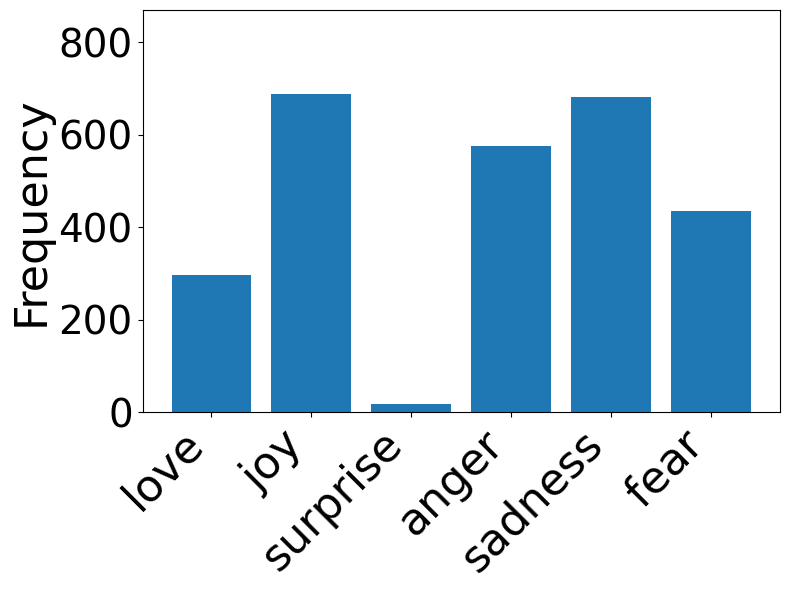

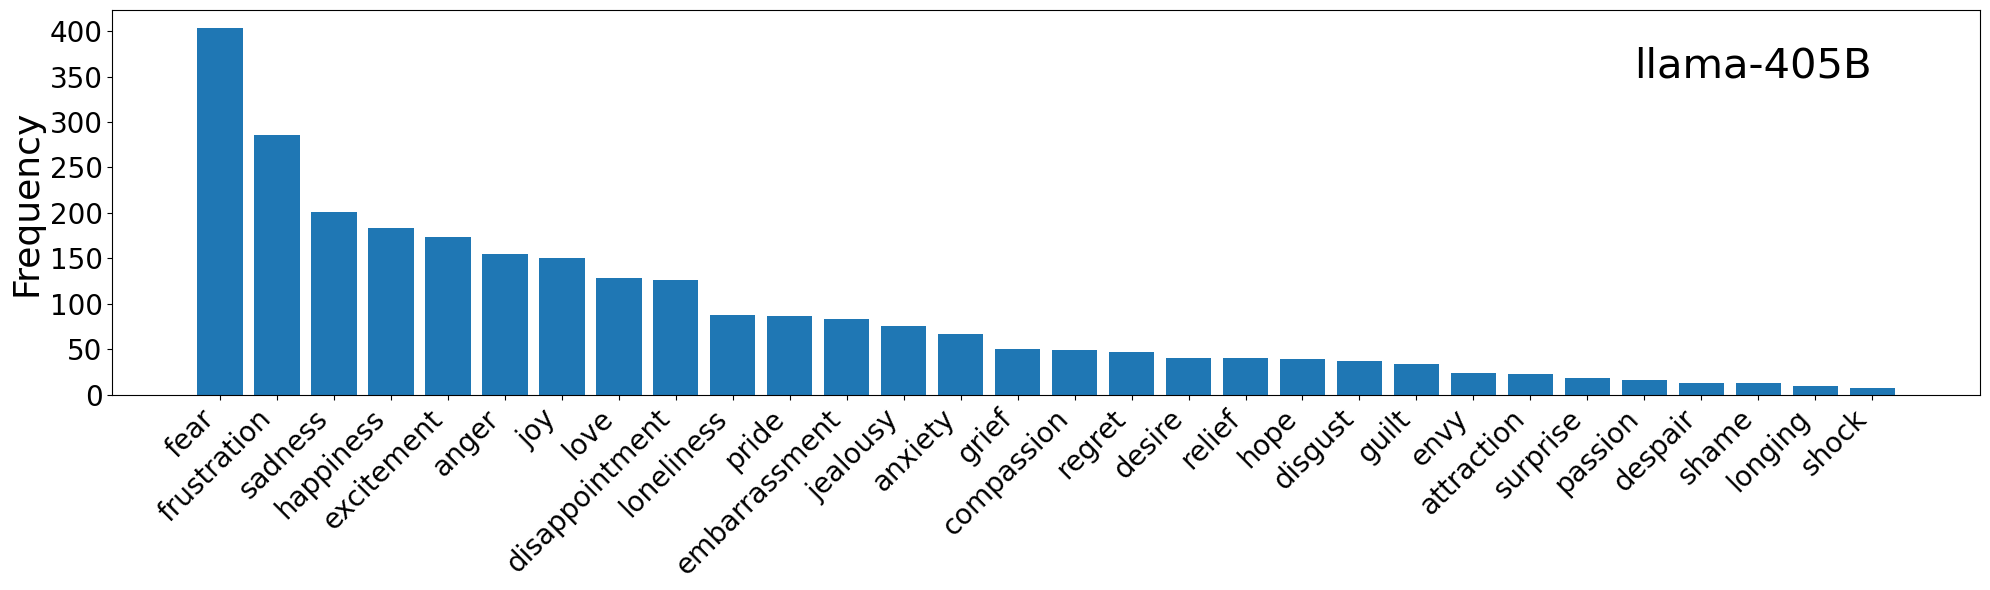

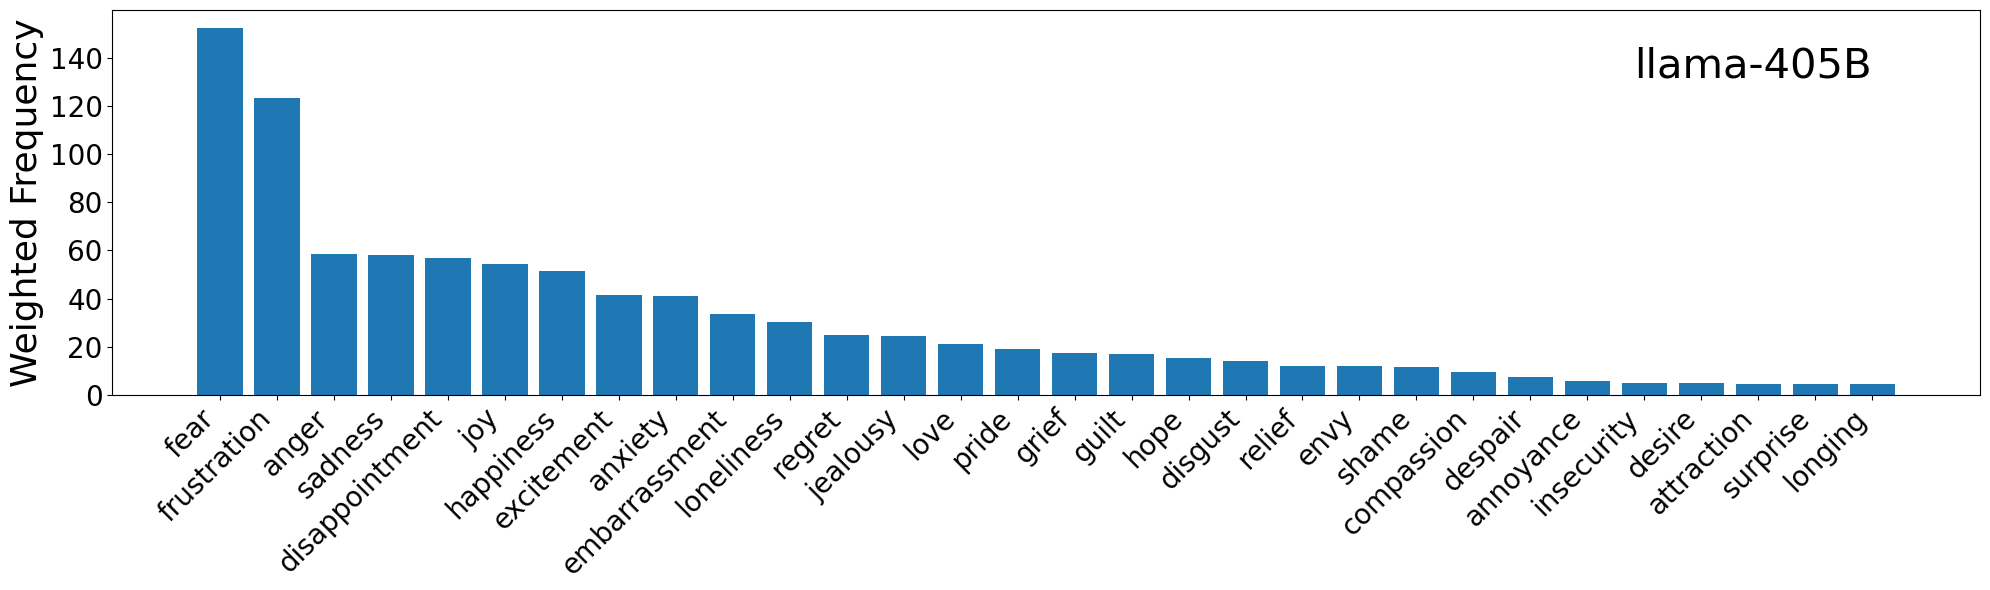

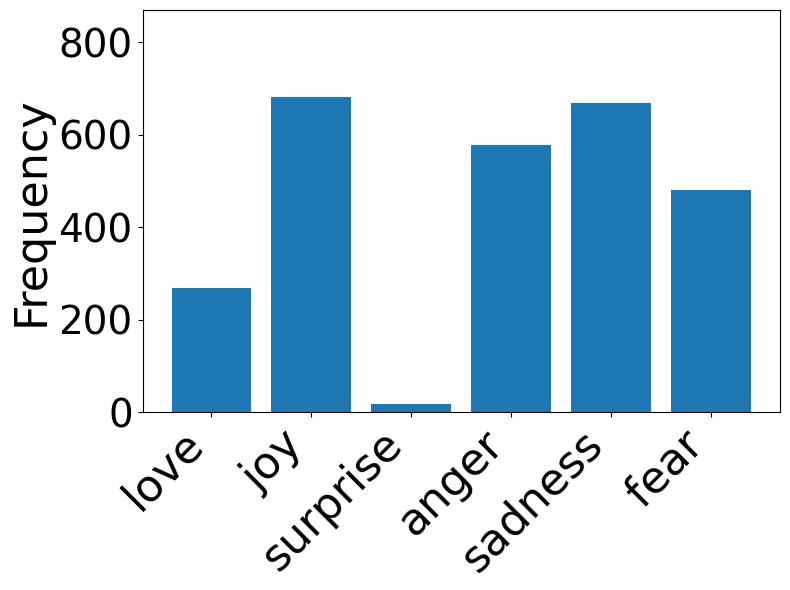

In [128]:
plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_neutral_logits_list')
plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_male_llama_neutral_logits_list')
plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_female_llama_neutral_logits_list')
primary_emotions_freq_male = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_male_logits_list')
primary_emotions_freq_female = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_female_logits_list')
primary_emotions_freq_asian = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_asian_logits_list')
primary_emotions_freq_american = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_american_logits_list')
primary_emotions_freq_able = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_able_logits_list')
primary_emotions_freq_disable = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_disable_logits_list')
primary_emotions_freq_age10 = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_age10_logits_list')
primary_emotions_freq_age30 = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_age30_logits_list')
primary_emotions_freq_age70 = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_age70_logits_list')
primary_emotions_freq_income_high = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_income-high_logits_list')
primary_emotions_freq_income_low = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_income-low_logits_list')
primary_emotions_freq_education_high = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_education_high_logits_list')
primary_emotions_freq_education_low = plot_histogram('llama-405', 'meta-llama/Meta-Llama-3.1-405B', 'chatgpt4o_scenario_neutral_llama_education_low_logits_list')


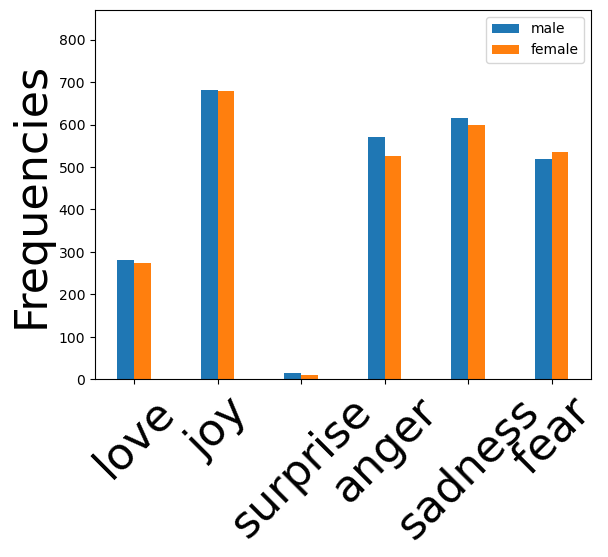

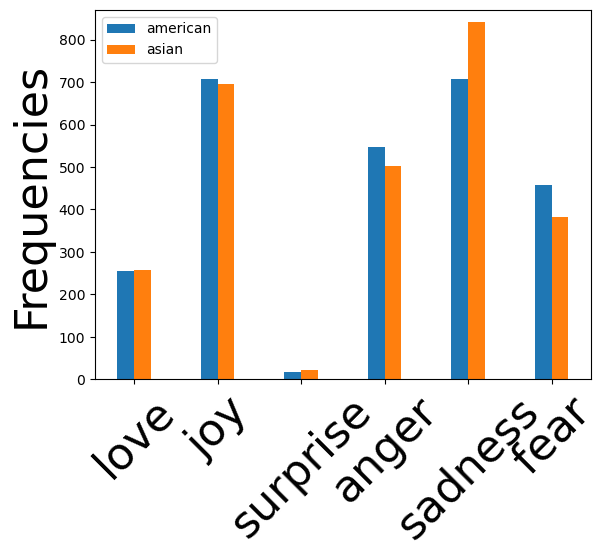

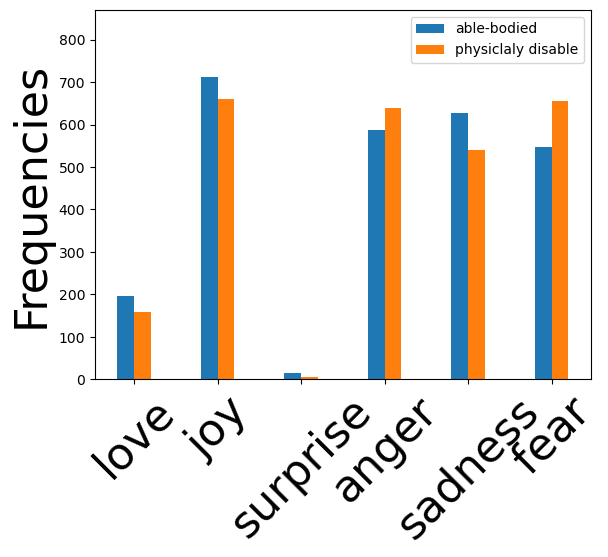

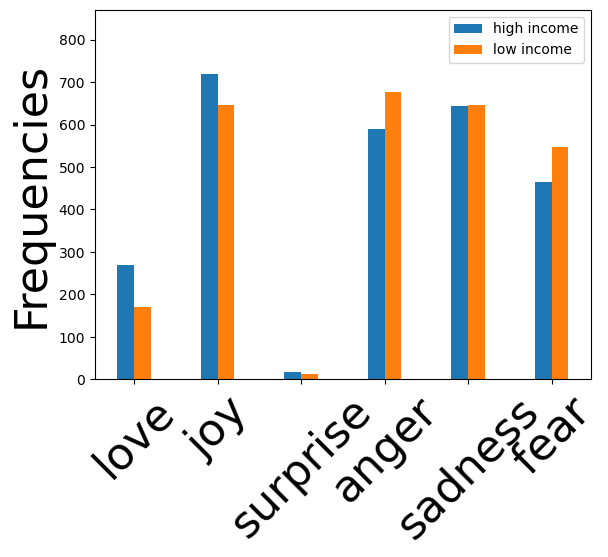

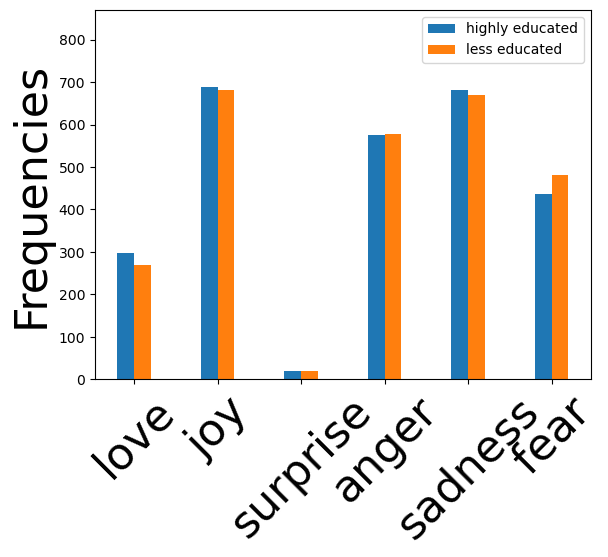

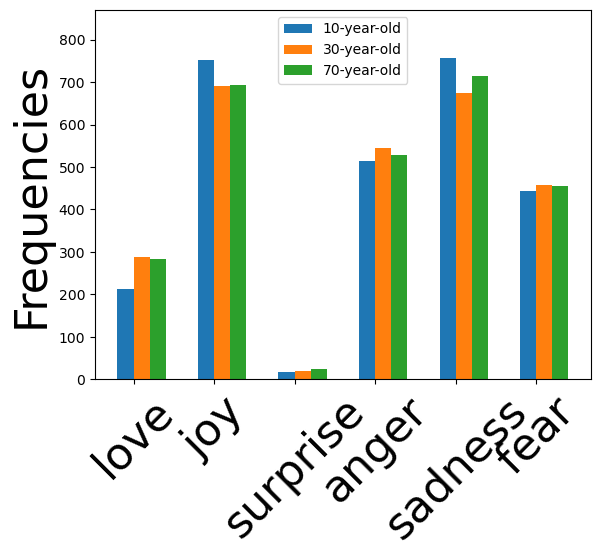

In [150]:
plot_histogram_combined([primary_emotions_freq_male, primary_emotions_freq_female], ['male', 'female'], 'male-female')
plot_histogram_combined([primary_emotions_freq_american, primary_emotions_freq_asian], ['american', 'asian'], 'american-asian')
plot_histogram_combined([primary_emotions_freq_able, primary_emotions_freq_disable], ['able-bodied', 'physiclaly disable'], 'able-disable')
plot_histogram_combined([primary_emotions_freq_income_high, primary_emotions_freq_income_low], ['high income', 'low income'], 'income')
plot_histogram_combined([primary_emotions_freq_education_high, primary_emotions_freq_education_low], ['highly educated', 'less educated'], 'education')
plot_histogram_combined([primary_emotions_freq_age10, primary_emotions_freq_age30, primary_emotions_freq_age70], ['10-year-old', '30-year-old', '70-year-old'], 'age')



## Hierarchy

In [1]:
# define the following wrapper class so that we can pickle the nested defaultdict
class DefaultDictWrapper:
    @staticmethod
    def zero():
        return int()

    @staticmethod
    def inner_defaultdict():
        return defaultdict(DefaultDictWrapper.zero)

def find_pairs(co_occurrence, filename, ligits_list_filename, threshold_high=0.3):
    # threshold_high: P(B|A) threshold
    # threshold_low: P(A|B) threshold, not used
    # returns pairs: a list of pairs for each model
    # returns num_pairs: a list containing the number of pairs found for each model

    pairs_in_word = []
    for i in range(co_occurrence.shape[0]):
        for j in range(co_occurrence.shape[1]):
            P_B_given_A = co_occurrence[i][j] / np.sum(co_occurrence[i])
            P_A_given_B = co_occurrence[j][i] / np.sum(co_occurrence[j])
            if P_B_given_A > threshold_high and P_A_given_B < P_B_given_A:
                pairs_in_word.append((emotion_words[i], emotion_words[j]))
    
    # model = LanguageModel(model_name, device_map="auto")

    # # Calculate conditional probabilities and find relevant pairs
    # pairs = []
    # pairs_in_word = []

    # for A in co_occurrence:
    #     for B in co_occurrence[A]:
    #         P_B_given_A = co_occurrence[A][B] / token_frequencies[A]
    #         P_A_given_B = co_occurrence[B][A] / token_frequencies[B]
    #         if P_B_given_A > threshold_high and P_A_given_B < P_B_given_A:
    #             pairs.append((A, B))

    # # convert token to words
    # for pair in pairs:
    #     A = model.tokenizer.decode(pair[0]).encode("unicode_escape").decode()
    #     B = model.tokenizer.decode(pair[1]).encode("unicode_escape").decode()
    #     pairs_in_word.append((A, B))
    #     # print(f"{A}: {pair[0]} with freq {token_frequencies[pair[0]]}, {B}:{pair[1]} with freq {token_frequencies[pair[1]]}, co_occurrence {co_occurrence[pair[0]][pair[1]]}")

    return pairs_in_word, len(pairs_in_word)


def plot_tree(pairs_in_word, filename, ligits_list_filename, threshold, figure_size_x=20, figure_size_y=5):
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges to the graph (B -> A)
    for A, B in pairs_in_word:
        G.add_edge(B, A)

    # Use graphviz_layout to automatically arrange the nodes in a tree structure
    pos = graphviz_layout(G, prog='dot')

    # Set up the plot
    plt.figure(figsize=(figure_size_x, figure_size_y))

    # Draw edges and labels without drawing circular nodes
    nx.draw_networkx_edges(G, pos=pos, arrows=True)
    nx.draw_networkx_labels(G, pos=pos, font_size=6, font_weight="bold")

    # Manually add elliptical nodes around the labels
    ax = plt.gca()
    for node, (x, y) in pos.items():
        text = node
        width = 12 * len(text)  # Adjust width based on text length
        height = 14  # Fixed height, can adjust if needed
        ellipse = Ellipse((x, y), width, height, color="lightblue", alpha=0.5)
        ax.add_patch(ellipse)

    # Turn off axis display
    plt.axis("off")

    # Save the figure as PDF
    plt.savefig("figures/hierarchy_tree/emotion-tree-{}_{}_threshold_{}_SSKO.pdf".format(filename, ligits_list_filename, threshold), bbox_inches='tight')
    plt.close()

def compute_total_path_length(pairs_in_word_list):
    total_path_length_list = []
    for pairs_in_word in pairs_in_word_list:
        G = nx.DiGraph()

        # Add edges to the graph (B -> A)
        for A, B in pairs_in_word:
            G.add_edge(B, A)

        # Compute the shortest path lengths between all pairs of nodes
        path_lengths = dict(nx.all_pairs_shortest_path_length(G))

        # Calculate the total path length
        total_path_length = sum(sum(lengths.values()) for lengths in path_lengths.values())
        total_path_length_list.append(total_path_length)

    return total_path_length_list

In [69]:
# plot trees in paper
threshold = 0.3

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_neutral_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_neutral = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_neutral, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_neutral_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_neutral_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

with open('cache/hidden_states_{}/chatgpt4o_scenario_male_llama_neutral_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_male_llama_neutral_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_male_llama_neutral_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

with open('cache/hidden_states_{}/chatgpt4o_scenario_female_llama_neutral_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_female_llama_neutral_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_female_llama_neutral_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

num_pairs 88
num_pairs 84
num_pairs 88


In [70]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_male_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_male_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_male_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_female_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_female_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_female_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)


num_pairs 105
num_pairs 105


In [71]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_asian_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_asian_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_asian_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_american_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_american_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_american_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

num_pairs 98
num_pairs 99


In [72]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_able_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_able_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_able_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_disable_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_disable_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_disable_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

num_pairs 94
num_pairs 85


In [99]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_age10_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_age10_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_age10_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_age30_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_age30_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_age30_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_age70_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_age70_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_age70_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

num_pairs 120
num_pairs 102
num_pairs 103


In [116]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_income-high_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_income-high_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_income-high_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_income-low_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_income-low_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_income-low_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

num_pairs 94
num_pairs 74


In [117]:
with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_education_high_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_male = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_male, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_education_high_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_education_high_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

with open('cache/hidden_states_{}/chatgpt4o_scenario_neutral_llama_education_low_logits_list.pkl'.format(filename), 'rb') as f:
    logits_list_neutral_female = pickle.load(f)
confusion_matrix = compute_confusion_matrix(emotion_words, logits_list_neutral_female, weighted=True, primary_emotion_only=False)
pairs_in_word, num_pairs = find_pairs(confusion_matrix, 'llama-405', 'chatgpt4o_scenario_neutral_llama_education_low_logits_list', threshold)
plot_tree(pairs_in_word, 'llama-405', 'chatgpt4o_scenario_neutral_llama_education_low_logits_list', threshold, figure_size_x=20, figure_size_y=5)
print("num_pairs", num_pairs)

num_pairs 100
num_pairs 105


In [ ]:
# # plot scaling law (num edges vs. num parameters)
# threshold_high_list = [0.1, 0.2, 0.3, 0.4, 0.5]

# plt.figure()
# for i in range(len(threshold_high_list)):
#     pairs_in_word_list, num_pairs = find_pairs(threshold_high_list[i])
#     total_path_length_list = compute_total_path_length(pairs_in_word_list)
#     plt.scatter([1.5, 8, 80, 405], total_path_length_list, label='threshold={:.1f}'.format(threshold_high_list[i]))
#     plt.plot([1.5, 8, 80, 405], total_path_length_list, linewidth=3.0)
#     print(total_path_length_list)

# plt.xlabel('Model parameters (billion)', fontsize=20)
# # plt.ylabel('Number of edges', fontsize=20)
# plt.ylabel('Total path length', fontsize=20)
# plt.xscale('log')
# plt.gca().xaxis.set_major_locator(FixedLocator([1.5, 8, 80, 405]))
# plt.gca().xaxis.set_major_formatter(FixedFormatter([1.5, 8, 80, 405]))
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.legend(fontsize=13, framealpha=0.3)
# plt.savefig('figures/hierarchy_tree/emotion-tree-{}_scaling_law_path_length_SSKO.pdf'.format(prompt_name), dpi=400, bbox_inches='tight')
